In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU, BatchNormalization, Input
from keras.optimizers import Adam

from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def create_train_model(train_X, train_y):
  # LSTM Model
  model_lstm = Sequential([
      Input(shape=(train_X.shape[1], train_X.shape[2])),
      LSTM(50, return_sequences=True),
      Dropout(0.2),
      LSTM(50),
      Dropout(0.2),
      Dense(50, activation='relu'),
      Dense(train_y.shape[1], activation='softmax')
  ])

  optimizer = Adam(learning_rate=0.001)
  model_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

  # Bi-LSTM Model
  model_bi_lstm = Sequential([
      Input(shape=(train_X.shape[1], train_X.shape[2])),
      Bidirectional(LSTM(50, return_sequences=True)),
      Dropout(0.2),
      Bidirectional(LSTM(50)),
      Dropout(0.2),
      Dense(50, activation='relu'),
      Dense(train_y.shape[1], activation='softmax')
  ])

  optimizer = Adam(learning_rate=0.001)
  model_bi_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

  # GRU Model
  model_gru = Sequential([
      Input(shape=(train_X.shape[1], train_X.shape[2])),
      GRU(50, return_sequences=True),
      Dropout(0.2),
      GRU(50),
      Dropout(0.2),
      Dense(50, activation='relu'),
      Dense(train_y.shape[1], activation='softmax')
  ])

  optimizer = Adam(learning_rate=0.001)
  model_gru.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

  # Bi-GRU Model
  model_bi_gru = Sequential([
      Input(shape=(train_X.shape[1], train_X.shape[2])),
      Bidirectional(GRU(50, return_sequences=True)),
      Dropout(0.2),
      Bidirectional(GRU(50)),
      Dropout(0.2),
      Dense(50, activation='relu'),
      Dense(train_y.shape[1], activation='softmax')
  ])

  optimizer = Adam(learning_rate=0.001)
  model_bi_gru.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

  print("Training LSTM...")
  history_lstm = model_lstm.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0)
  print("Training Bi-LSTM...")
  history_bi_lstm = model_bi_lstm.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0)
  print("Training GRU...")
  history_gru = model_gru.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0)
  print("Training Bi-GRU...")
  history_bi_gru = model_bi_gru.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0)

  return model_lstm, model_bi_lstm, model_gru, model_bi_gru, history_lstm, history_bi_lstm, history_gru, history_bi_gru

In [3]:
def plot_loss(history_lstm, history_bi_lstm, history_gru, history_bi_gru, day):
  # List of histories
  histories = [history_lstm, history_bi_lstm, history_gru, history_bi_gru]

  # Corresponding model names
  model_names = ['LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU']

  # Create a 2x2 grid for subplots (which will fit 5 plots perfectly)
  fig, axs = plt.subplots(2, 2, figsize=(10, 8))

  for i, model_history in enumerate(histories):
      # Determine the subplot location
      row = i // 2
      col = i % 2
      ax = axs[row, col]

      # Get loss and validation loss
      loss = model_history.history['loss']
      val_loss = model_history.history['val_loss']

      # Get number of epochs
      epochs = range(len(loss))

      # Plot training and validation loss
      ax.plot(epochs, loss, 'r', label='Training loss')
      ax.plot(epochs, val_loss, 'b', label='Validation loss')
      ax.set_title(f'{day} days Loss for {model_names[i]}')
      ax.legend()

  plt.tight_layout()
  plt.show()

In [4]:
def evaluate_model(model, model_name, val_X, val_y):
    # Stack predictions for RNN models
    model_pred = model.predict(val_X)
    model_pred = np.argmax(model_pred, axis=1) - 1 # subtract 1 to get original categories

    # Calculate accuracy
    print(f"{model_name} Accuracy = {accuracy_score(val_y, model_pred)}\n")

    return model_pred

def ensemble(pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru, val_X, val_y):
    # Stack predictions to perform majority voting for All Models
    all_predictions = np.stack((pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru), axis=1)

    # Perform majority voting
    voted_predictions, _ = mode(all_predictions, axis=1)

    # Flatten the voted_predictions array
    voted_predictions = voted_predictions.ravel()

    # Calculate accuracy
    print(f"Ensemble Accuracy = {accuracy_score(val_y, voted_predictions)}\n")
    return voted_predictions

def ensemble_just_bi(pred_bi_lstm, pred_bi_gru, val_X, val_y):
    # Stack predictions to perform majority voting for Bidirectional Only
    all_predictions = np.stack((pred_bi_lstm, pred_bi_gru), axis=1)

    # Perform majority voting
    voted_predictions, _ = mode(all_predictions, axis=1)

    # Flatten the voted_predictions array
    voted_predictions = voted_predictions.ravel()

    # Calculate accuracy
    print(f"Ensemble Bi Accuracy = {accuracy_score(val_y, voted_predictions)}\n")
    return voted_predictions

In [ ]:
stocks = ["ANTM", "BMRI", "BNGA", "EXCL", "INCO", "INKP", "MEDC"]
days = [1,5,10,20,50]

ANTM Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


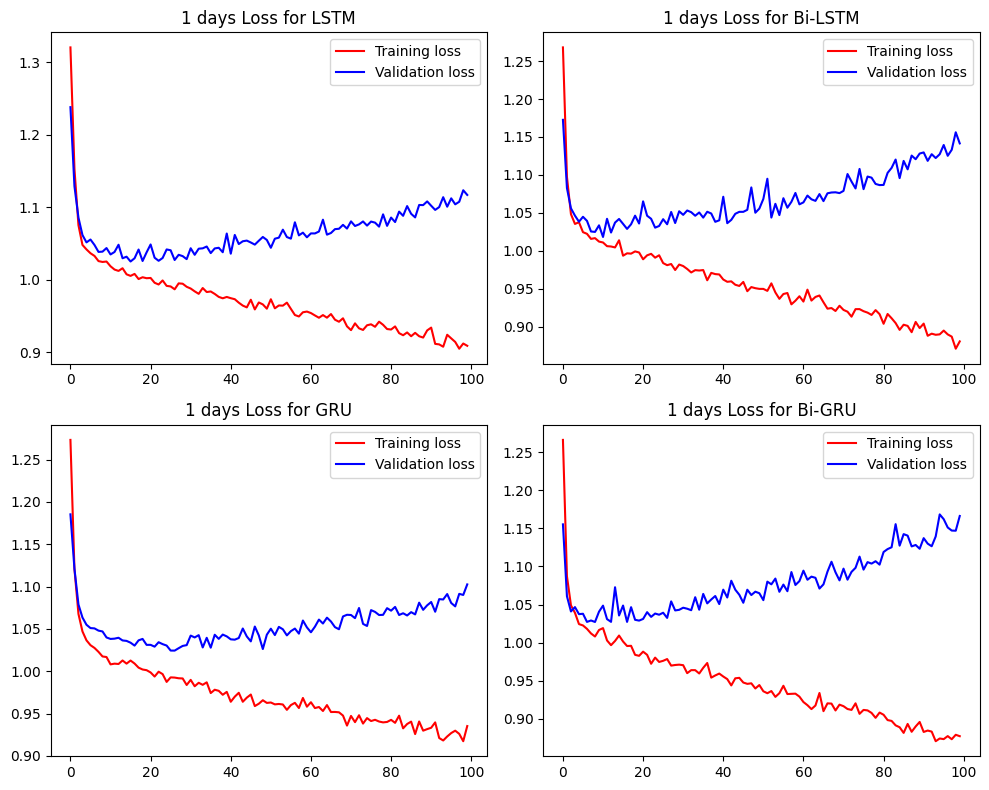

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
LSTM Accuracy = 0.47950819672131145

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
Bi-LSTM Accuracy = 0.5

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
GRU Accuracy = 0.5040983606557377

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Bi-GRU Accuracy = 0.4713114754098361

Ensemble Accuracy = 0.5122950819672131

Ensemble Bi Accuracy = 0.4918032786885246

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

ANTM Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


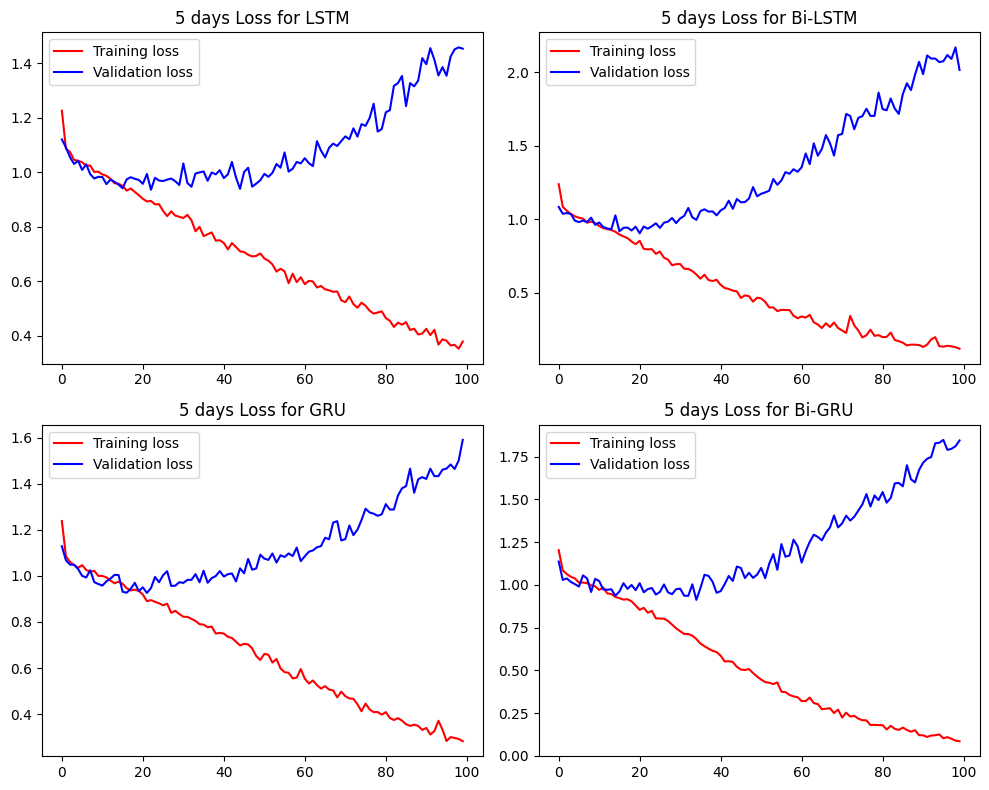

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
LSTM Accuracy = 0.5491803278688525

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
Bi-LSTM Accuracy = 0.6311475409836066

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
GRU Accuracy = 0.5245901639344263

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Bi-GRU Accuracy = 0.6229508196721312

Ensemble Accuracy = 0.5983606557377049

Ensemble Bi Accuracy = 0.6147540983606558

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

ANTM Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


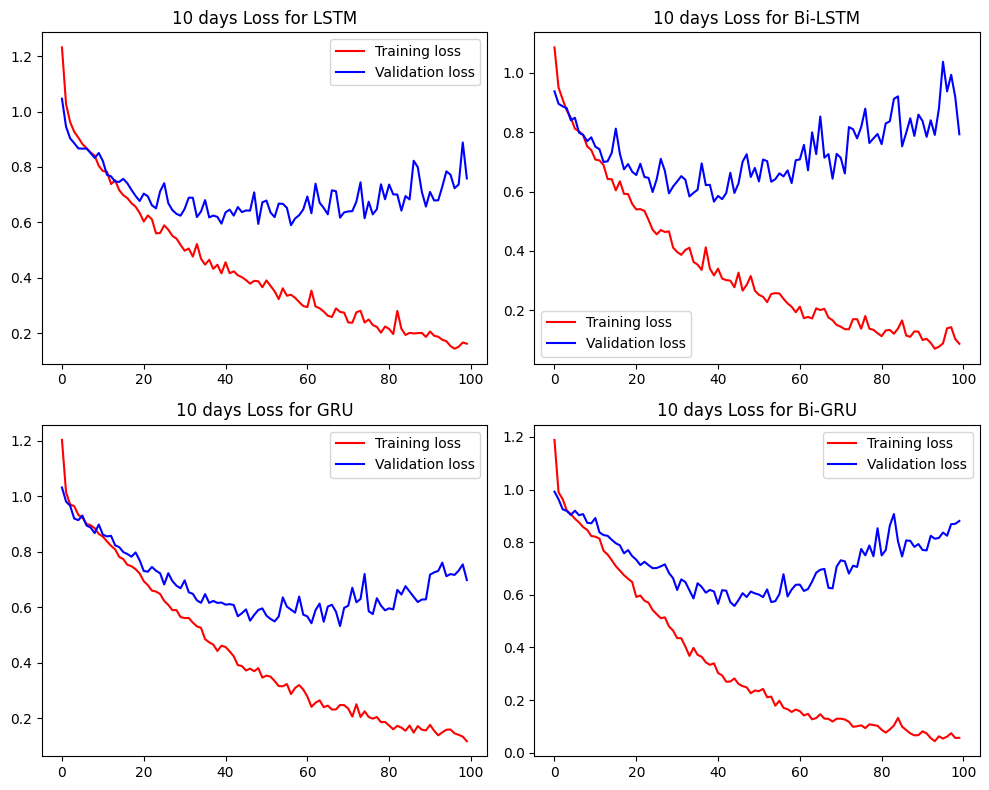

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
LSTM Accuracy = 0.8032786885245902

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Bi-LSTM Accuracy = 0.7827868852459017

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
GRU Accuracy = 0.7909836065573771

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Bi-GRU Accuracy = 0.8032786885245902

Ensemble Accuracy = 0.7991803278688525

Ensemble Bi Accuracy = 0.7991803278688525

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

ANTM Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


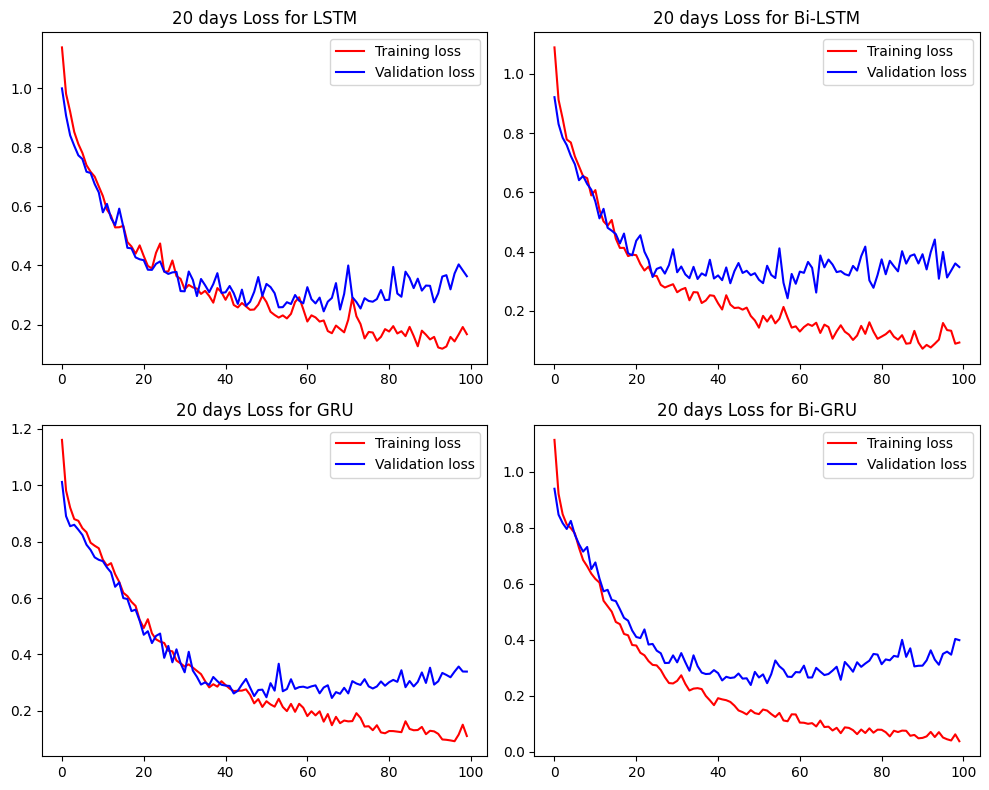

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
LSTM Accuracy = 0.8729508196721312

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
Bi-LSTM Accuracy = 0.889344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
GRU Accuracy = 0.8770491803278688

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Bi-GRU Accuracy = 0.8770491803278688

Ensemble Accuracy = 0.8934426229508197

Ensemble Bi Accuracy = 0.8811475409836066

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

ANTM Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


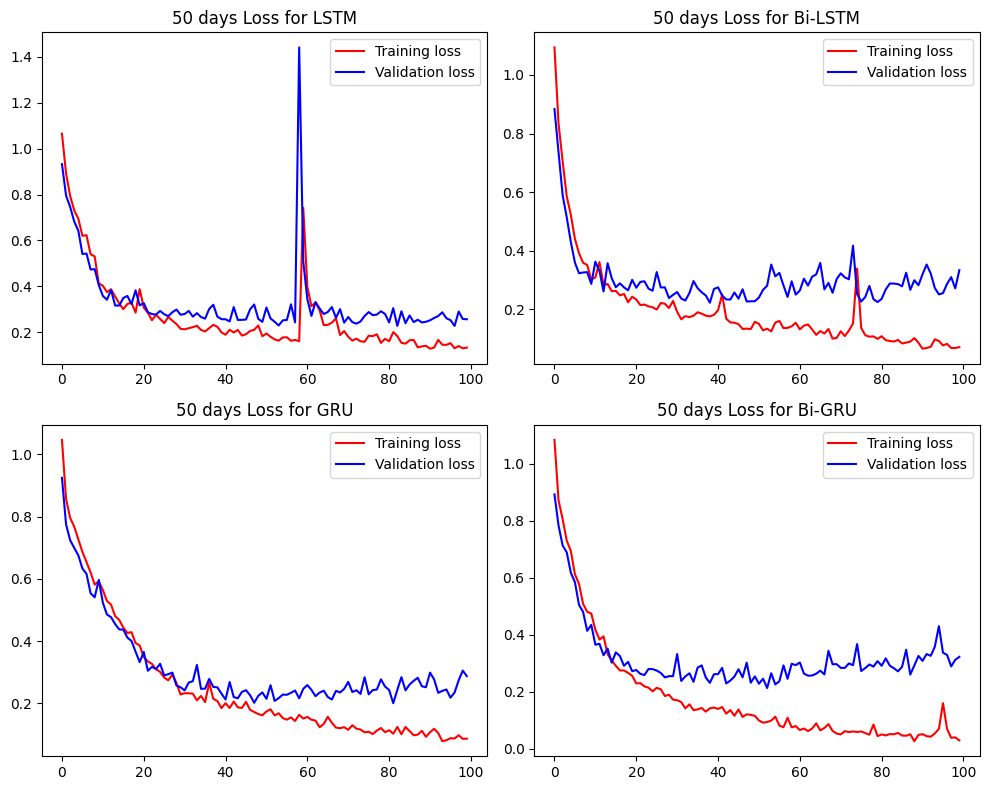

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
LSTM Accuracy = 0.9057377049180327

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step
Bi-LSTM Accuracy = 0.9180327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
GRU Accuracy = 0.9098360655737705

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
Bi-GRU Accuracy = 0.9344262295081968

Ensemble Accuracy = 0.9221311475409836

Ensemble Bi Accuracy = 0.930327868852459

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BMRI Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


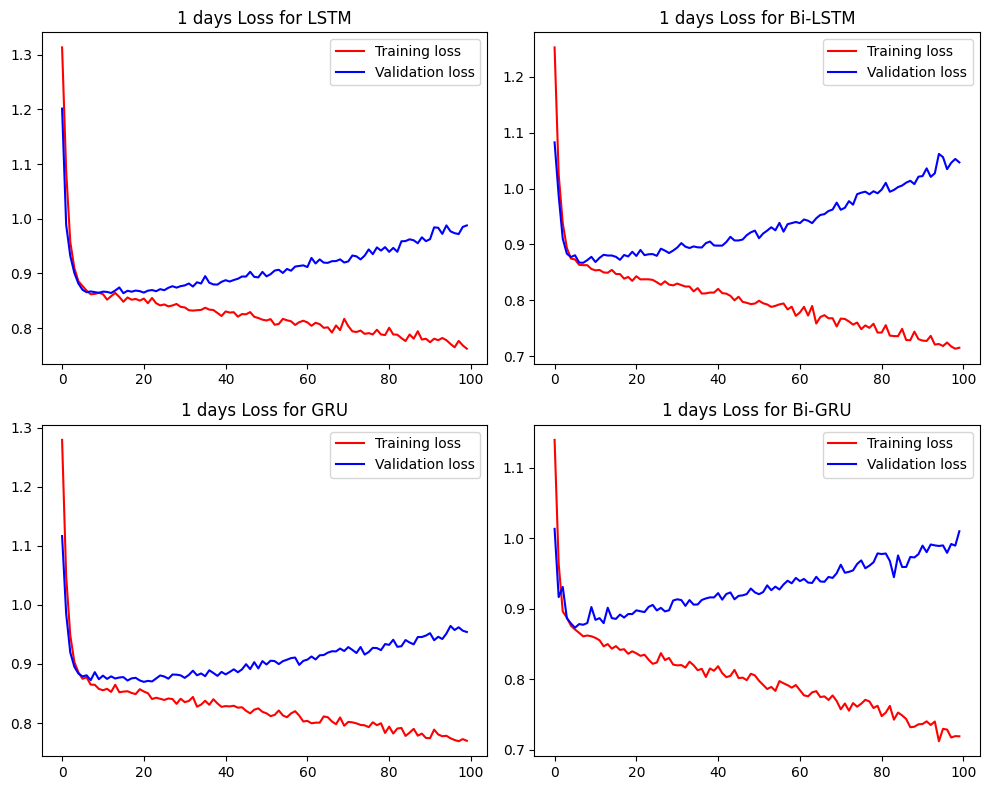

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
LSTM Accuracy = 0.6065573770491803

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Bi-LSTM Accuracy = 0.5901639344262295

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU Accuracy = 0.6188524590163934

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Bi-GRU Accuracy = 0.5860655737704918

Ensemble Accuracy = 0.6065573770491803

Ensemble Bi Accuracy = 0.5983606557377049

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BMRI Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


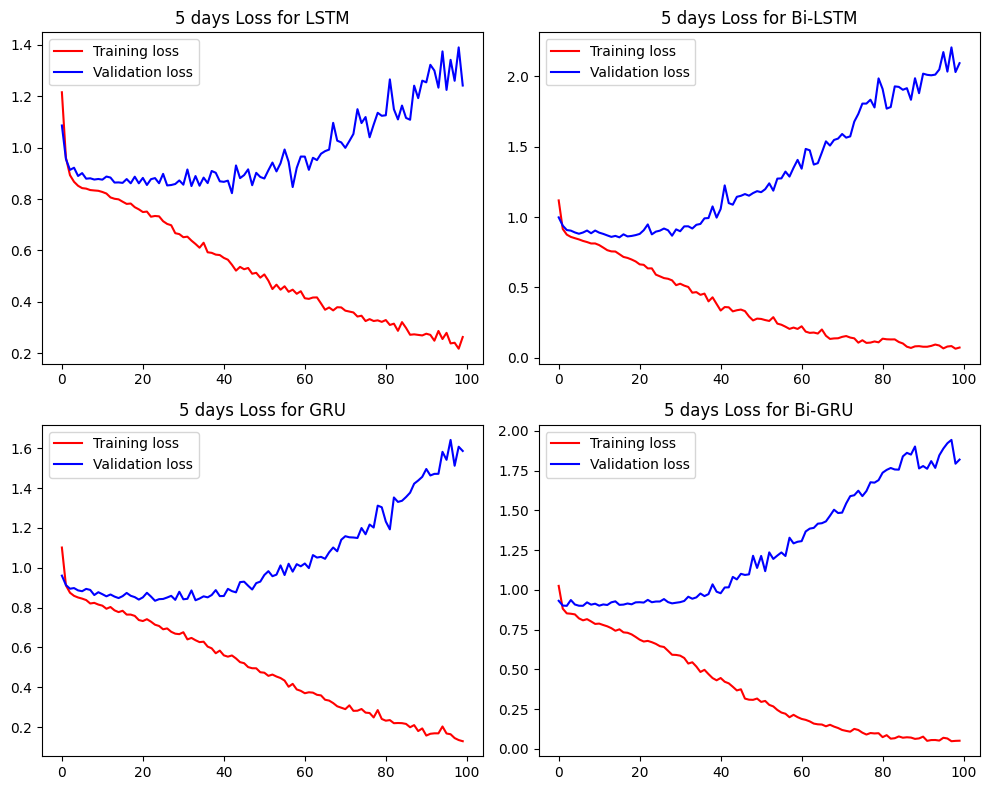

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.6762295081967213

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Bi-LSTM Accuracy = 0.639344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU Accuracy = 0.6926229508196722

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Bi-GRU Accuracy = 0.6721311475409836

Ensemble Accuracy = 0.7008196721311475

Ensemble Bi Accuracy = 0.6680327868852459

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BMRI Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


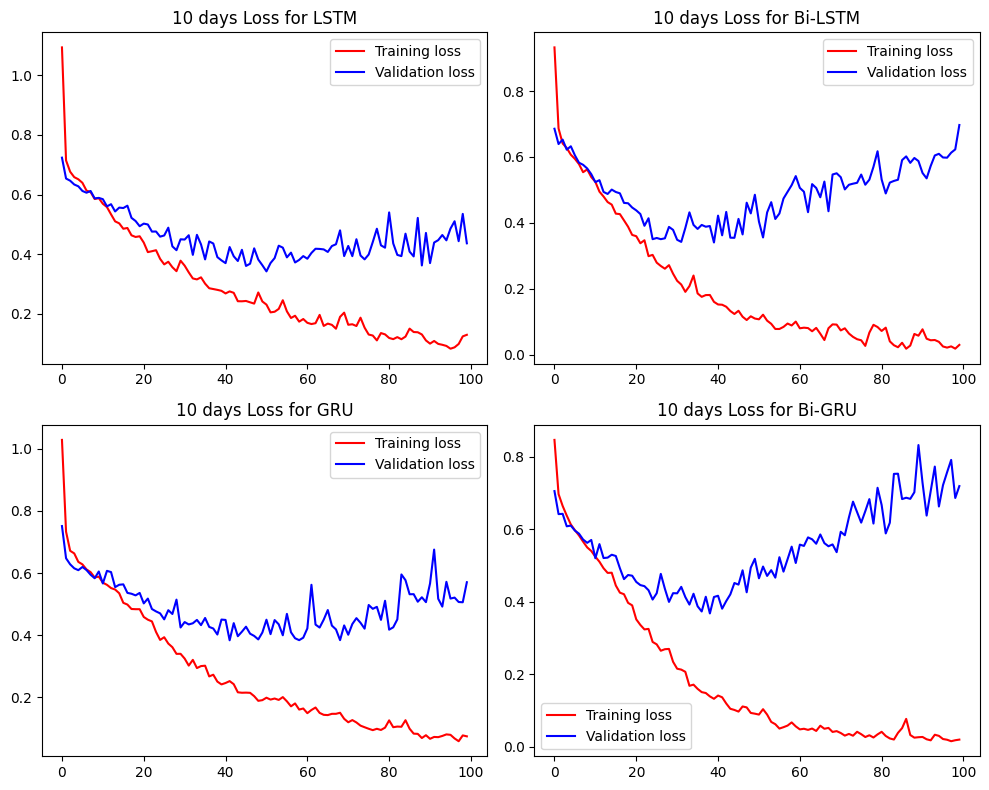

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
LSTM Accuracy = 0.8688524590163934

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
Bi-LSTM Accuracy = 0.8483606557377049

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
GRU Accuracy = 0.8524590163934426

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
Bi-GRU Accuracy = 0.8483606557377049

Ensemble Accuracy = 0.8770491803278688

Ensemble Bi Accuracy = 0.860655737704918

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BMRI Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


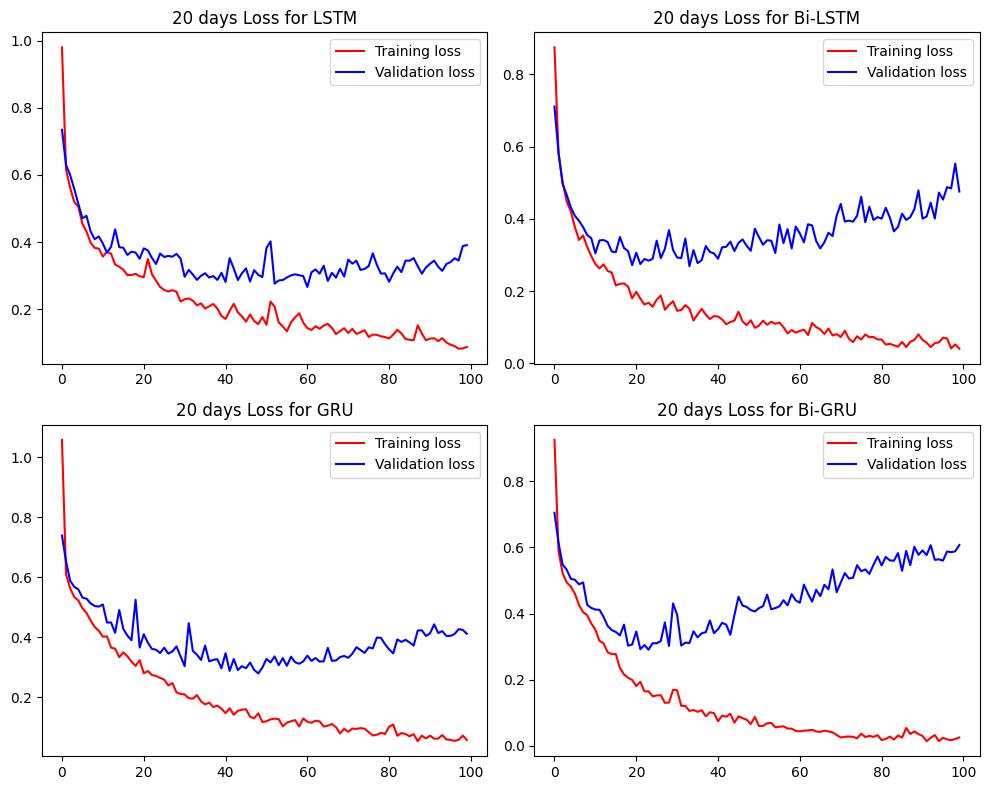

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
LSTM Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
Bi-LSTM Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
GRU Accuracy = 0.9139344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
Bi-GRU Accuracy = 0.8975409836065574

Ensemble Accuracy = 0.9016393442622951

Ensemble Bi Accuracy = 0.8975409836065574

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BMRI Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


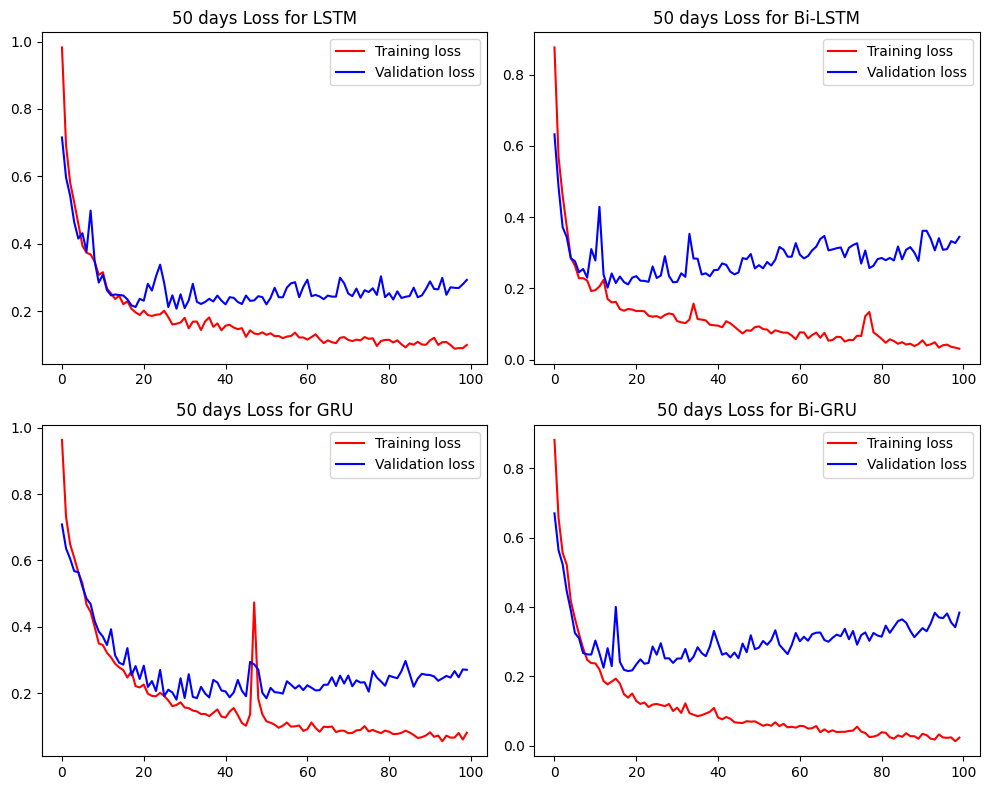

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
LSTM Accuracy = 0.9139344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Bi-LSTM Accuracy = 0.9467213114754098

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
GRU Accuracy = 0.9344262295081968

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
Bi-GRU Accuracy = 0.9180327868852459

Ensemble Accuracy = 0.9344262295081968

Ensemble Bi Accuracy = 0.930327868852459

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BNGA Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


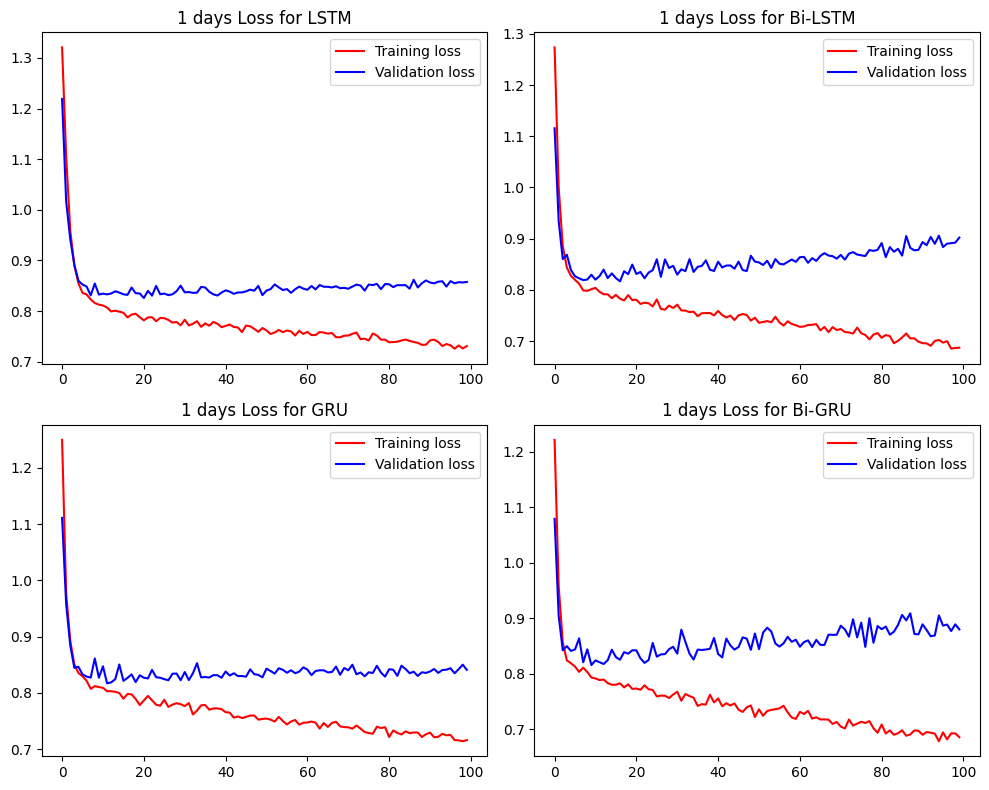

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
LSTM Accuracy = 0.6967213114754098

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Bi-LSTM Accuracy = 0.6762295081967213

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU Accuracy = 0.7090163934426229

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Bi-GRU Accuracy = 0.6885245901639344

Ensemble Accuracy = 0.6967213114754098

Ensemble Bi Accuracy = 0.6844262295081968

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BNGA Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


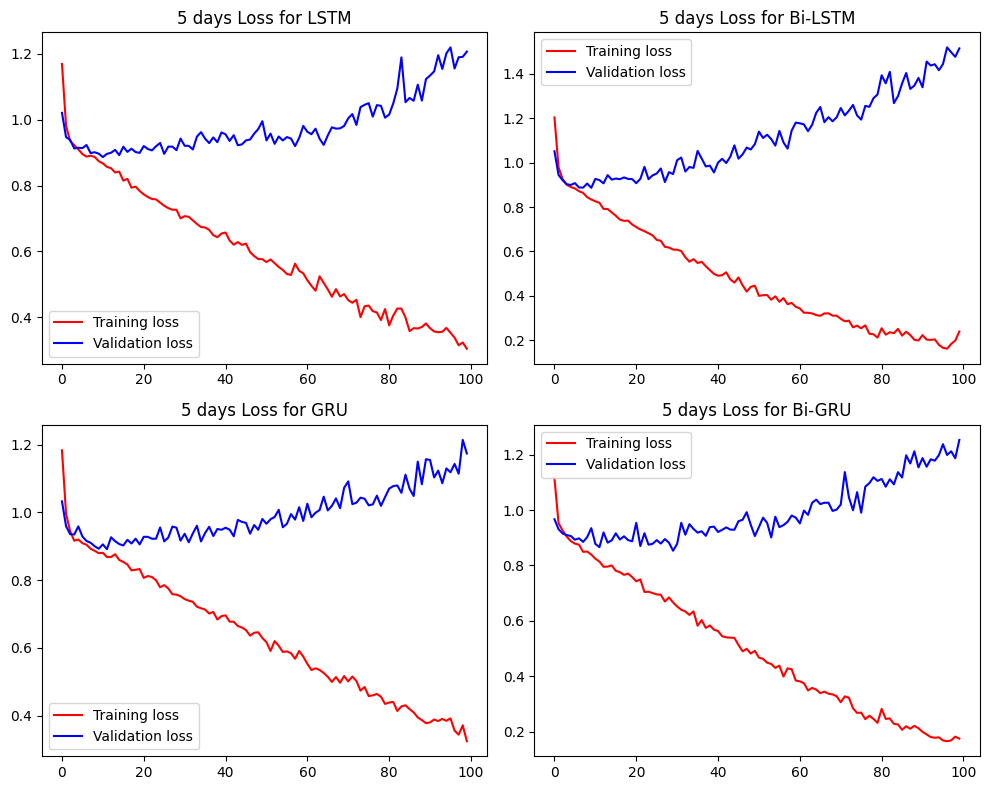

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
LSTM Accuracy = 0.680327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Bi-LSTM Accuracy = 0.7049180327868853

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
GRU Accuracy = 0.6721311475409836

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
Bi-GRU Accuracy = 0.7172131147540983

Ensemble Accuracy = 0.7049180327868853

Ensemble Bi Accuracy = 0.7008196721311475

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BNGA Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


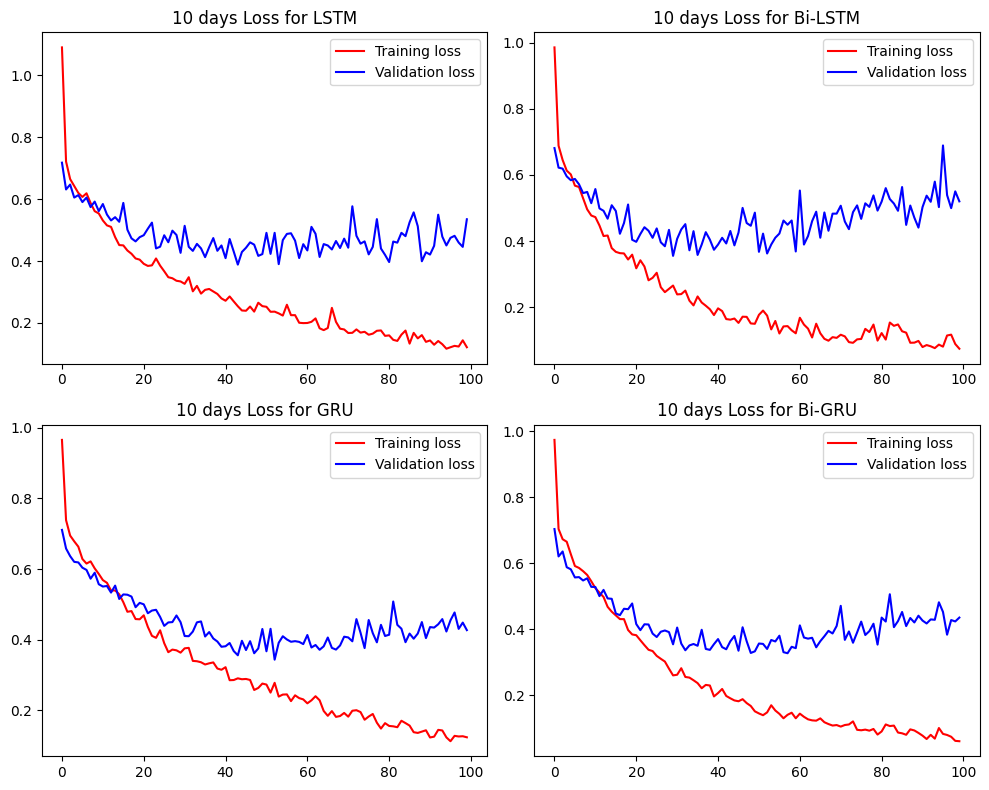

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
LSTM Accuracy = 0.8524590163934426

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Bi-LSTM Accuracy = 0.8729508196721312

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU Accuracy = 0.8729508196721312

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
Bi-GRU Accuracy = 0.9016393442622951

Ensemble Accuracy = 0.8934426229508197

Ensemble Bi Accuracy = 0.8934426229508197

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BNGA Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


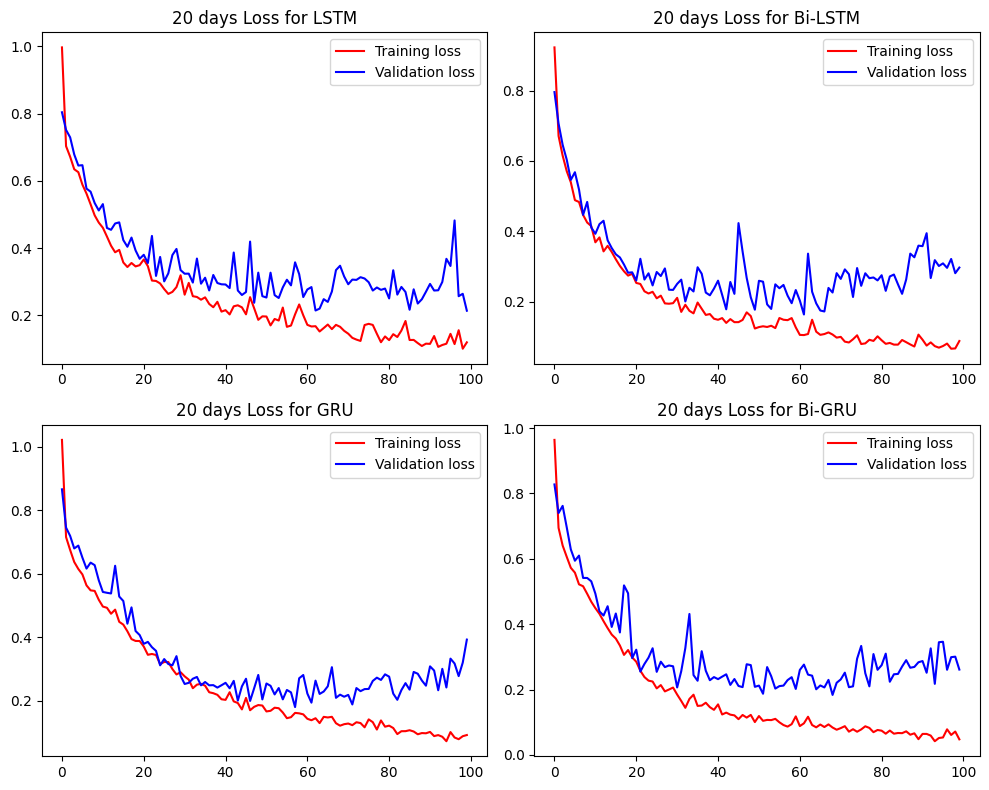

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
LSTM Accuracy = 0.930327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Bi-LSTM Accuracy = 0.930327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
GRU Accuracy = 0.9016393442622951

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
Bi-GRU Accuracy = 0.9221311475409836

Ensemble Accuracy = 0.9221311475409836

Ensemble Bi Accuracy = 0.930327868852459

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

BNGA Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


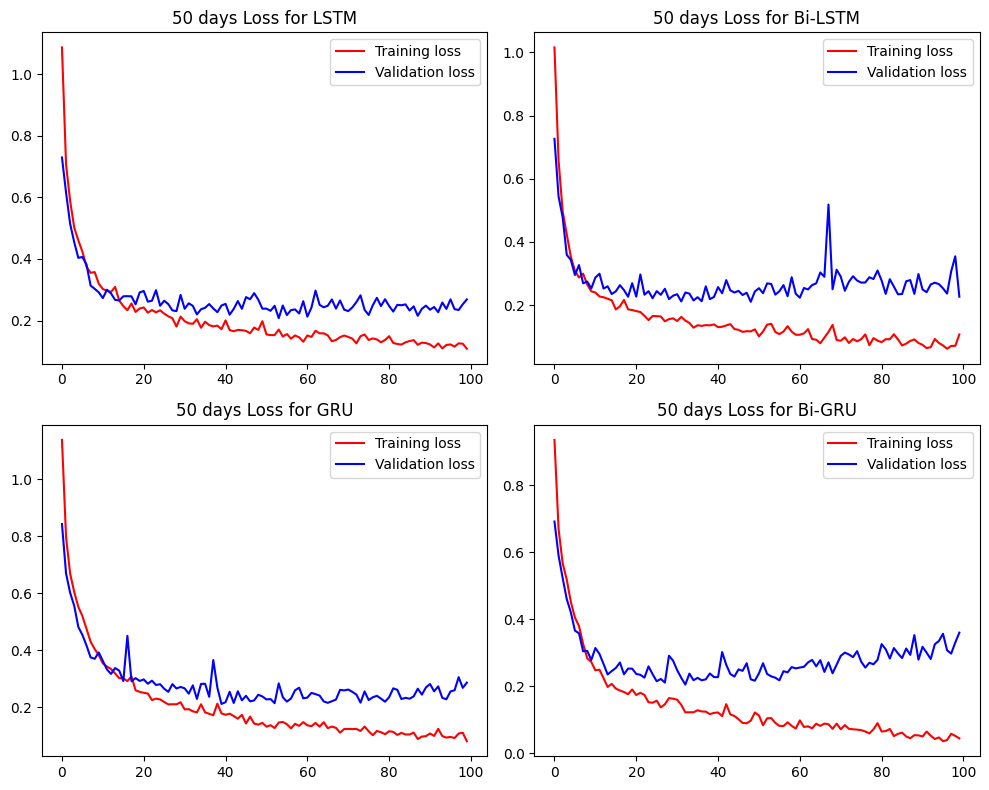

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
LSTM Accuracy = 0.9262295081967213

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Bi-LSTM Accuracy = 0.9508196721311475

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
GRU Accuracy = 0.9139344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
Bi-GRU Accuracy = 0.9180327868852459

Ensemble Accuracy = 0.9385245901639344

Ensemble Bi Accuracy = 0.9344262295081968

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

EXCL Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


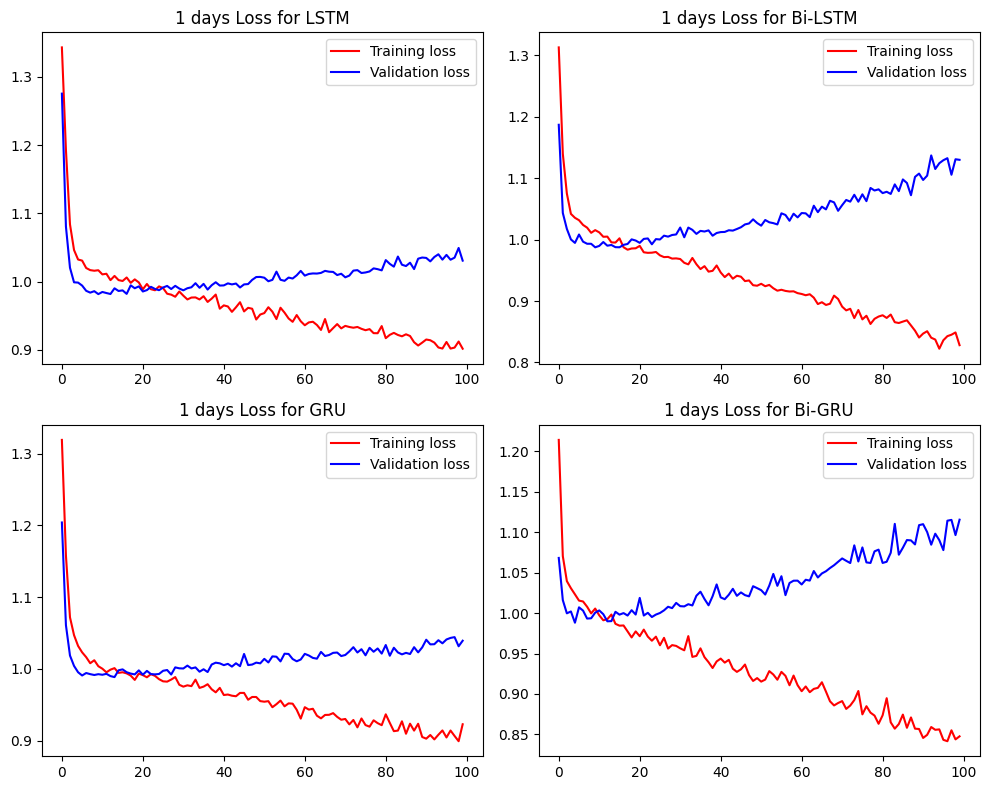

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM Accuracy = 0.5327868852459017

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Bi-LSTM Accuracy = 0.4959016393442623

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
GRU Accuracy = 0.5368852459016393

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Bi-GRU Accuracy = 0.5

Ensemble Accuracy = 0.5163934426229508

Ensemble Bi Accuracy = 0.4959016393442623

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

EXCL Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


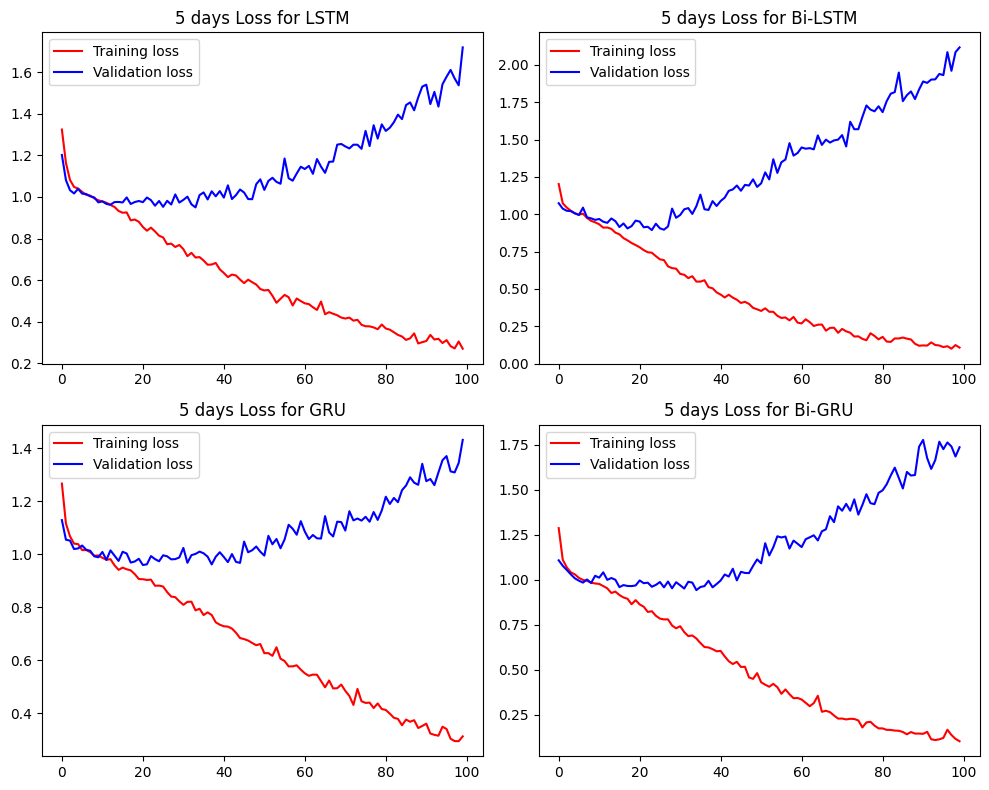

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
LSTM Accuracy = 0.5655737704918032

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step
Bi-LSTM Accuracy = 0.5901639344262295

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU Accuracy = 0.5614754098360656

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Bi-GRU Accuracy = 0.6024590163934426

Ensemble Accuracy = 0.5737704918032787

Ensemble Bi Accuracy = 0.5737704918032787

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

EXCL Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


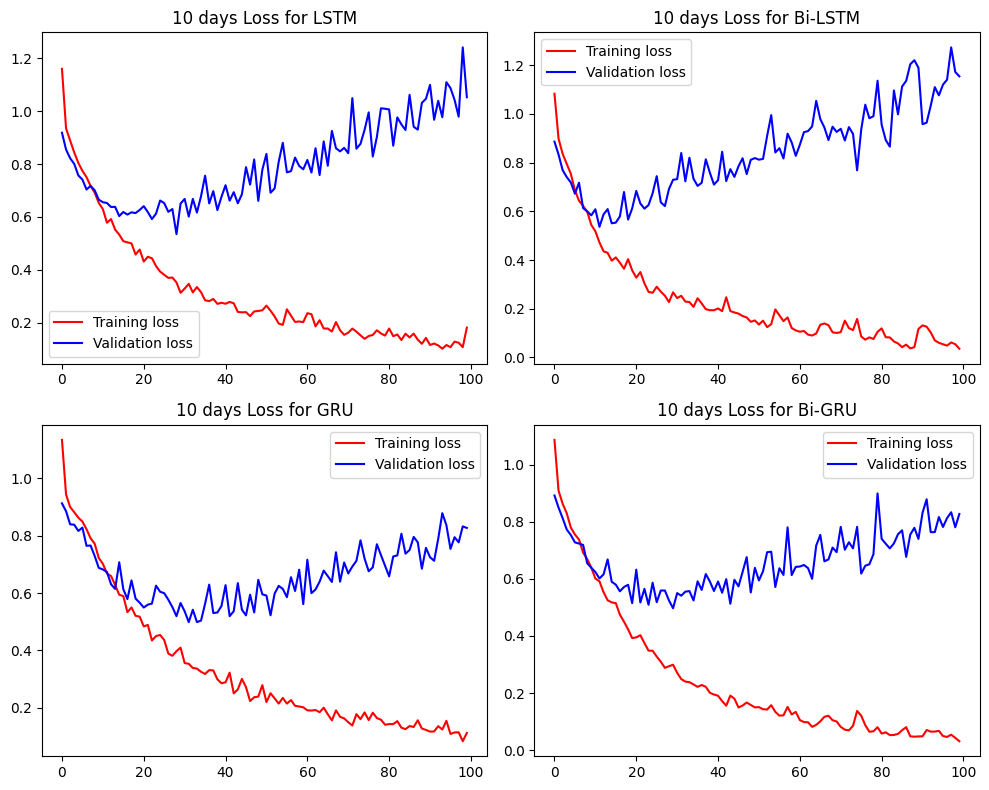

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.7459016393442623

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Bi-LSTM Accuracy = 0.7868852459016393

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
GRU Accuracy = 0.7950819672131147

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
Bi-GRU Accuracy = 0.8114754098360656

Ensemble Accuracy = 0.7950819672131147

Ensemble Bi Accuracy = 0.8073770491803278

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

EXCL Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


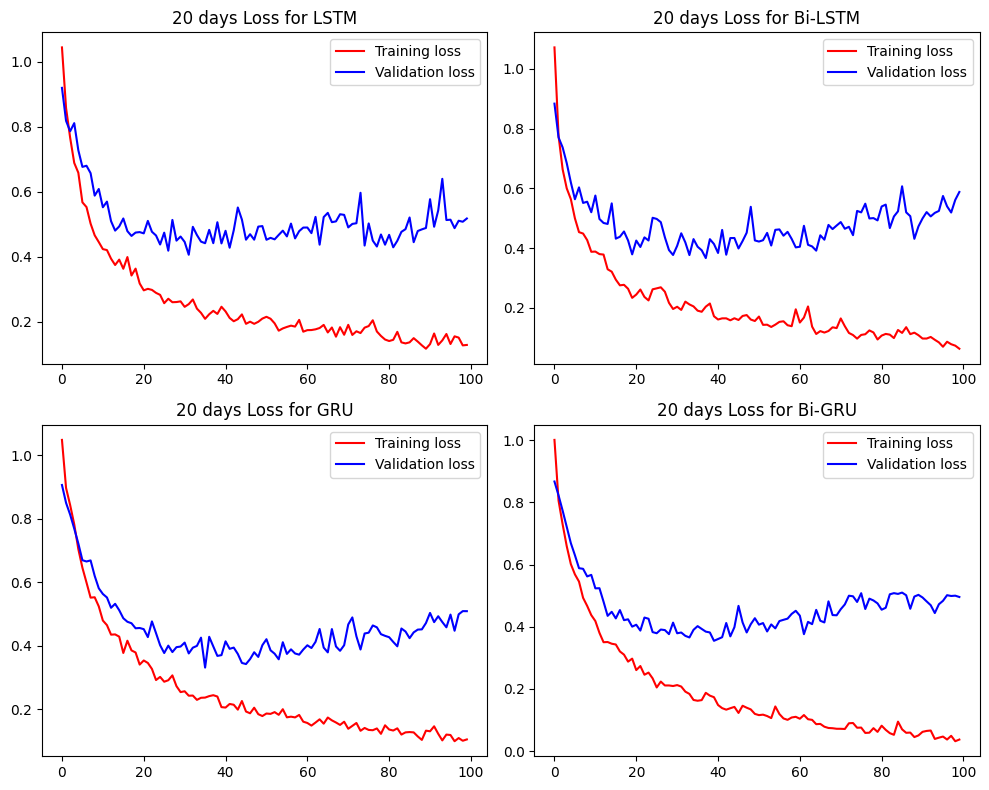

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
LSTM Accuracy = 0.8647540983606558

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Bi-LSTM Accuracy = 0.860655737704918

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
GRU Accuracy = 0.8688524590163934

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Bi-GRU Accuracy = 0.8975409836065574

Ensemble Accuracy = 0.8811475409836066

Ensemble Bi Accuracy = 0.8770491803278688

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

EXCL Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


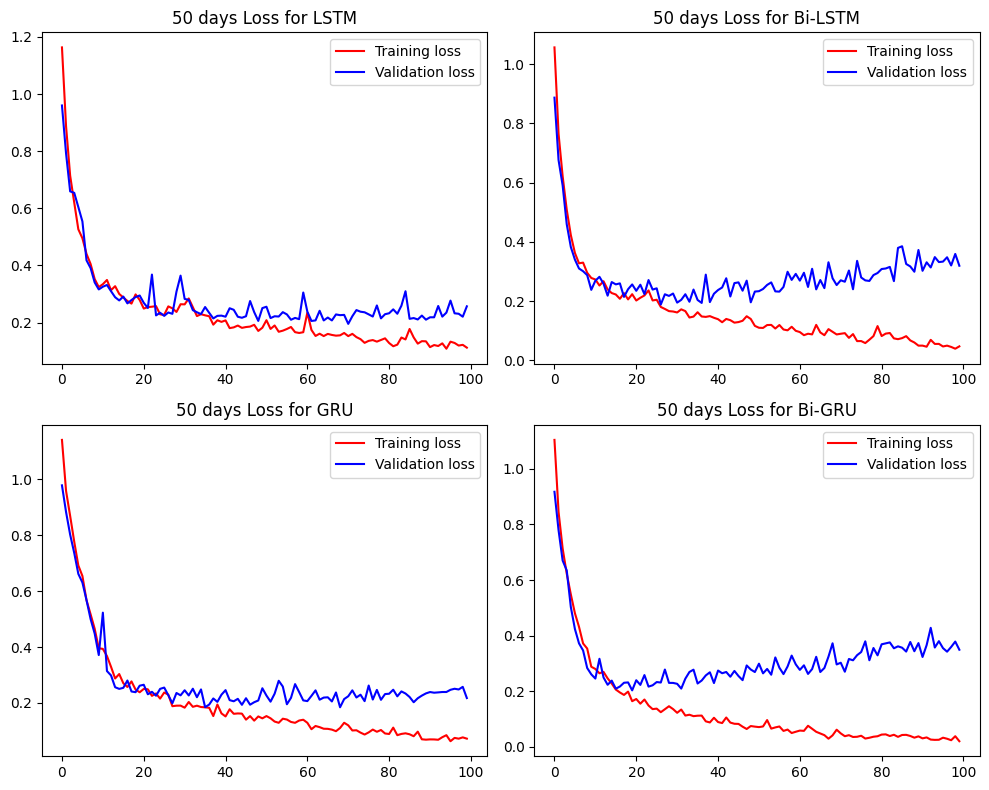

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
LSTM Accuracy = 0.9016393442622951

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
Bi-LSTM Accuracy = 0.9057377049180327

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
GRU Accuracy = 0.9262295081967213

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step
Bi-GRU Accuracy = 0.9139344262295082

Ensemble Accuracy = 0.9098360655737705

Ensemble Bi Accuracy = 0.9098360655737705

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INCO Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


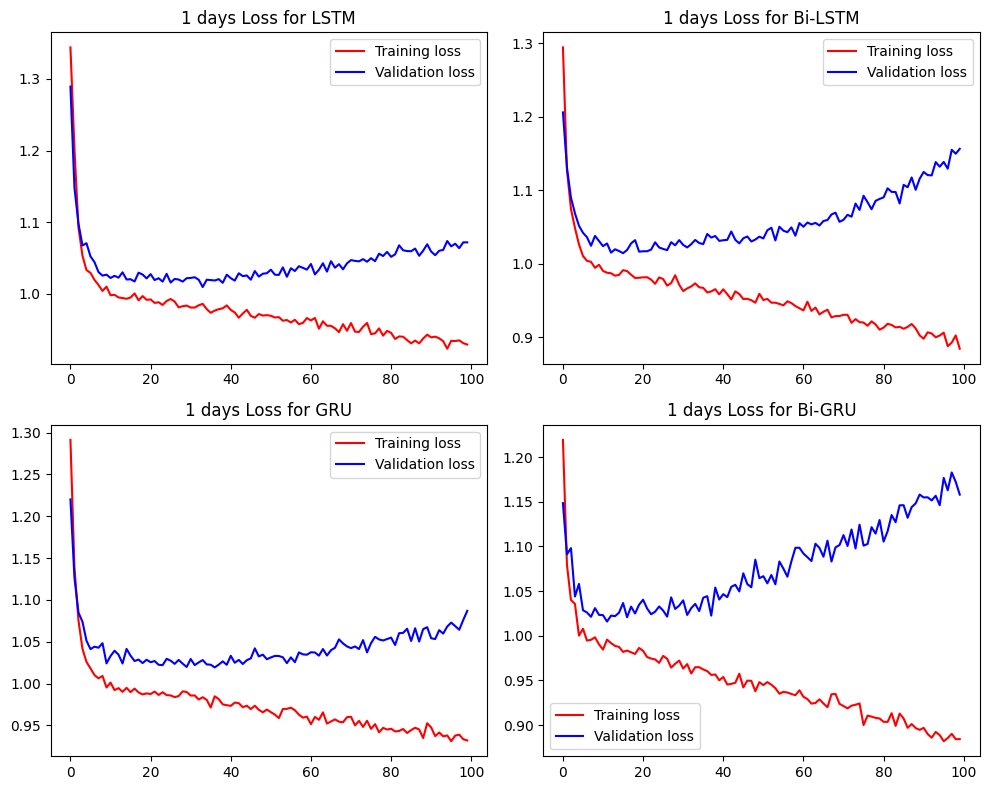

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.46311475409836067

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Bi-LSTM Accuracy = 0.4713114754098361

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU Accuracy = 0.4713114754098361

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
Bi-GRU Accuracy = 0.46311475409836067

Ensemble Accuracy = 0.47950819672131145

Ensemble Bi Accuracy = 0.4672131147540984

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INCO Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


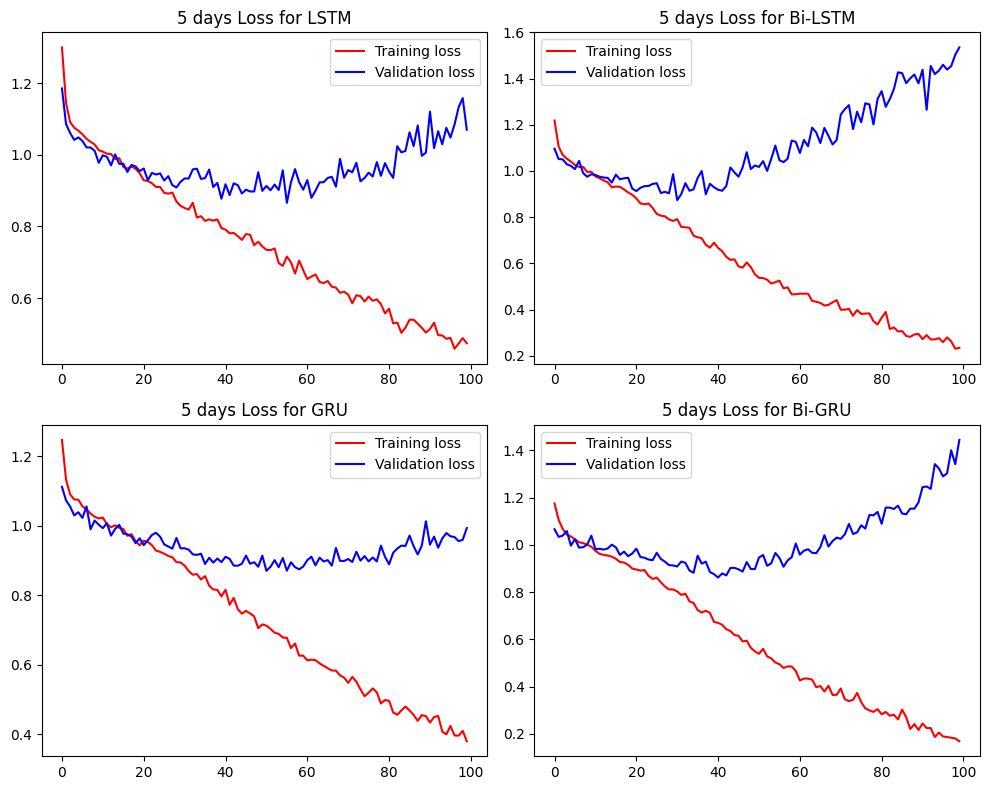

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
LSTM Accuracy = 0.6147540983606558

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Bi-LSTM Accuracy = 0.6229508196721312

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
GRU Accuracy = 0.5983606557377049

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Bi-GRU Accuracy = 0.6024590163934426

Ensemble Accuracy = 0.6188524590163934

Ensemble Bi Accuracy = 0.5901639344262295

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INCO Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


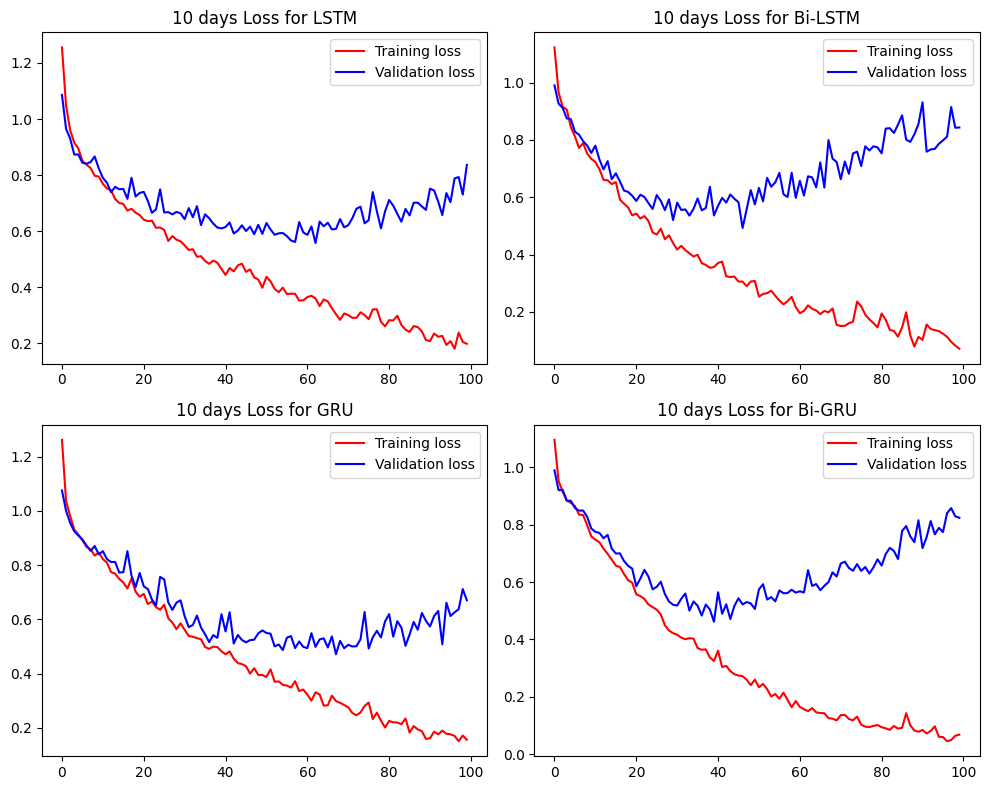

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
LSTM Accuracy = 0.7827868852459017

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Bi-LSTM Accuracy = 0.7991803278688525

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
GRU Accuracy = 0.7622950819672131

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step
Bi-GRU Accuracy = 0.8114754098360656

Ensemble Accuracy = 0.8155737704918032

Ensemble Bi Accuracy = 0.7827868852459017

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INCO Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


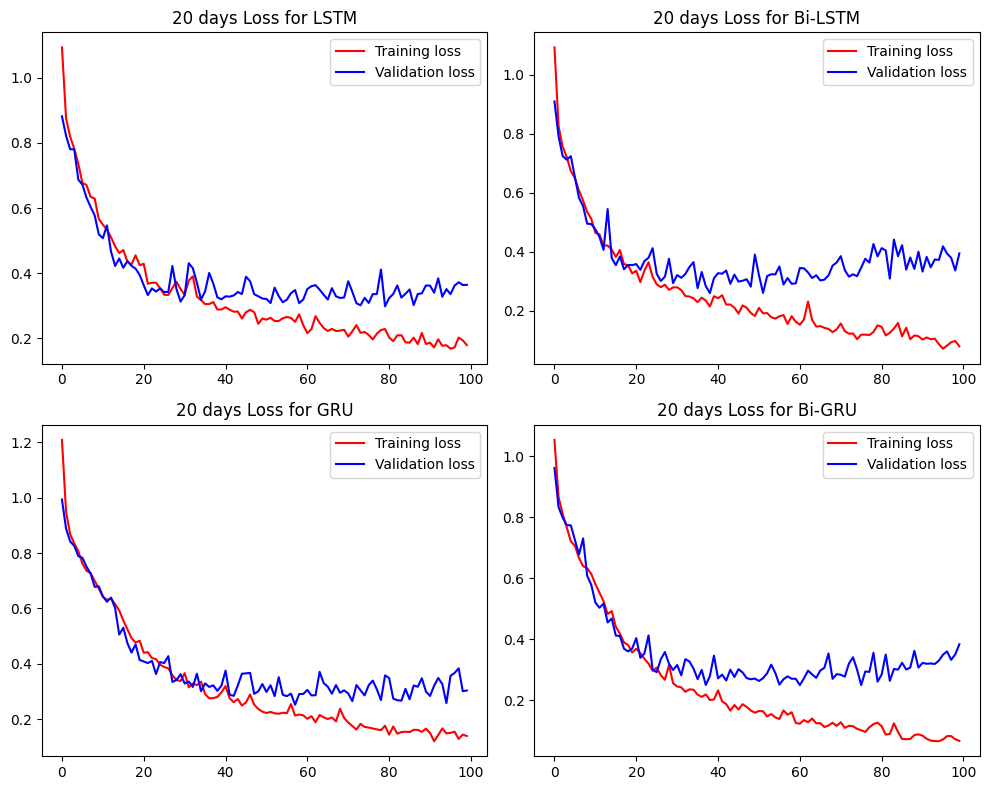

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
LSTM Accuracy = 0.8688524590163934

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
Bi-LSTM Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
GRU Accuracy = 0.9180327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
Bi-GRU Accuracy = 0.8852459016393442

Ensemble Accuracy = 0.8975409836065574

Ensemble Bi Accuracy = 0.8688524590163934

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INCO Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


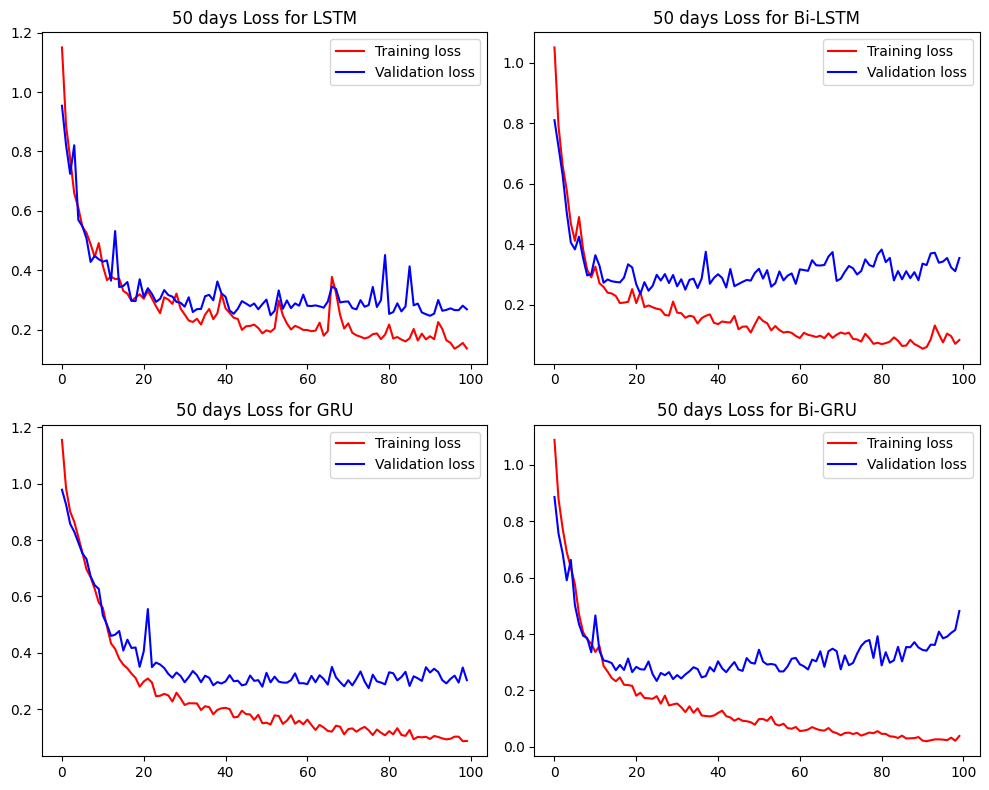

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
LSTM Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
Bi-LSTM Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
GRU Accuracy = 0.9098360655737705

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Bi-GRU Accuracy = 0.8975409836065574

Ensemble Accuracy = 0.9139344262295082

Ensemble Bi Accuracy = 0.8934426229508197

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INKP Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


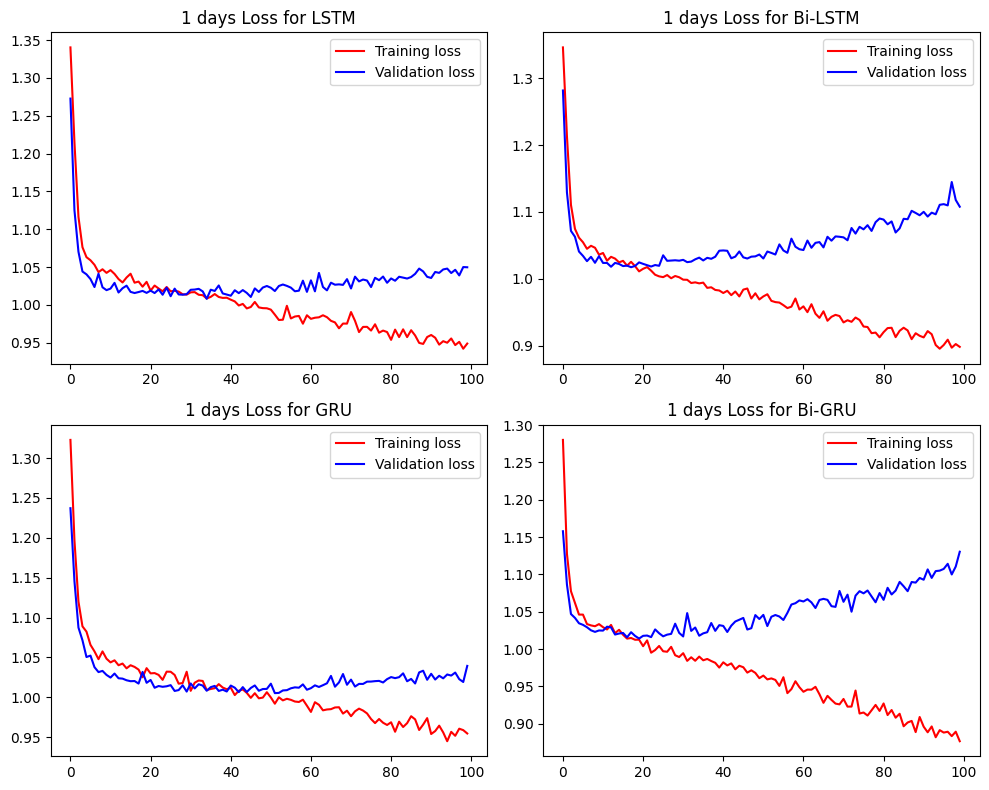

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.47950819672131145

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
Bi-LSTM Accuracy = 0.5122950819672131

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
GRU Accuracy = 0.47540983606557374

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step
Bi-GRU Accuracy = 0.4713114754098361

Ensemble Accuracy = 0.47950819672131145

Ensemble Bi Accuracy = 0.47950819672131145

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INKP Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


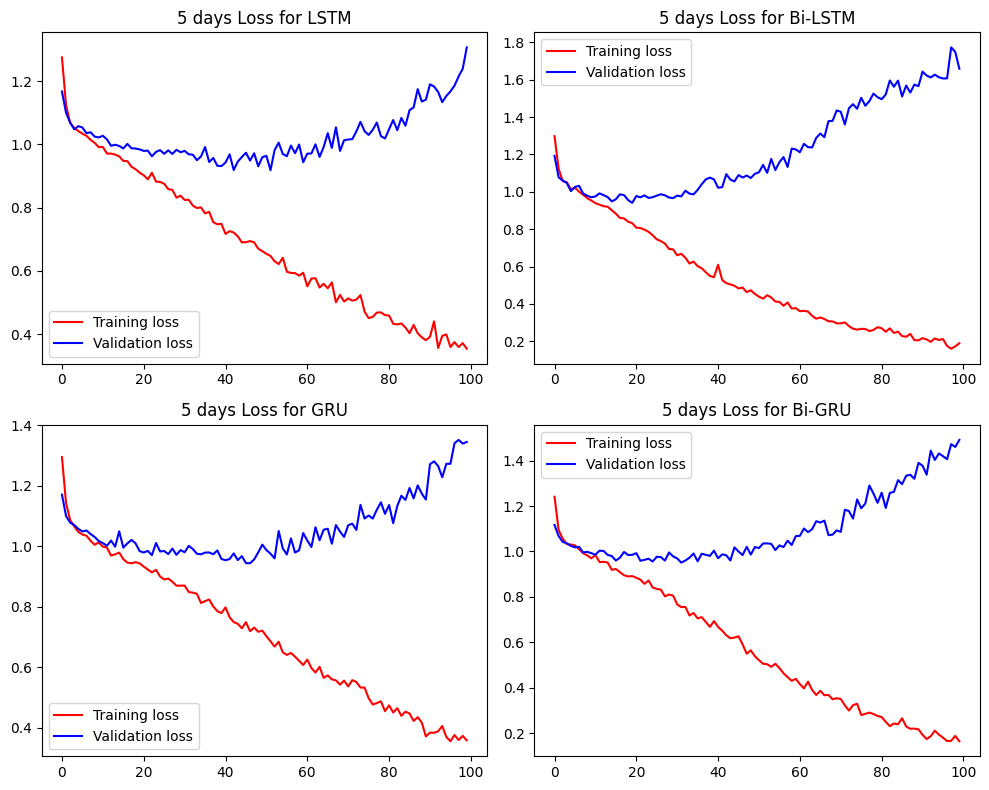

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
LSTM Accuracy = 0.6270491803278688

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Bi-LSTM Accuracy = 0.6311475409836066

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU Accuracy = 0.5491803278688525

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step
Bi-GRU Accuracy = 0.6024590163934426

Ensemble Accuracy = 0.639344262295082

Ensemble Bi Accuracy = 0.5942622950819673

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INKP Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


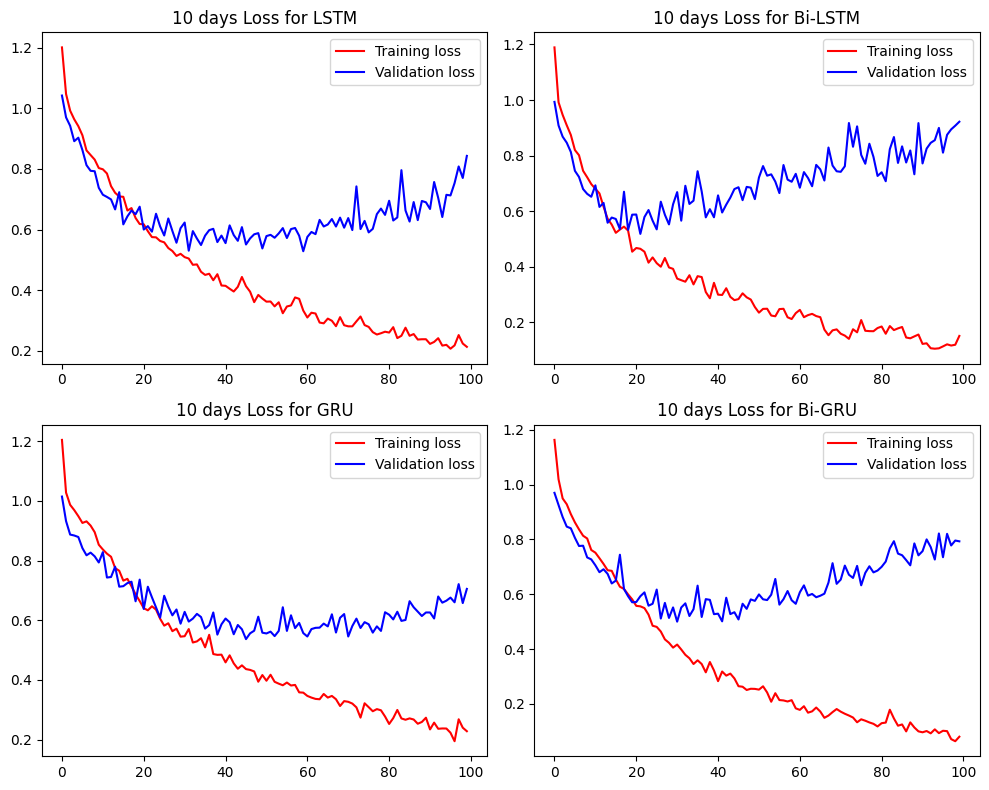

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
LSTM Accuracy = 0.7663934426229508

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step
Bi-LSTM Accuracy = 0.7991803278688525

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU Accuracy = 0.7991803278688525

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
Bi-GRU Accuracy = 0.8319672131147541

Ensemble Accuracy = 0.8278688524590164

Ensemble Bi Accuracy = 0.8155737704918032

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INKP Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


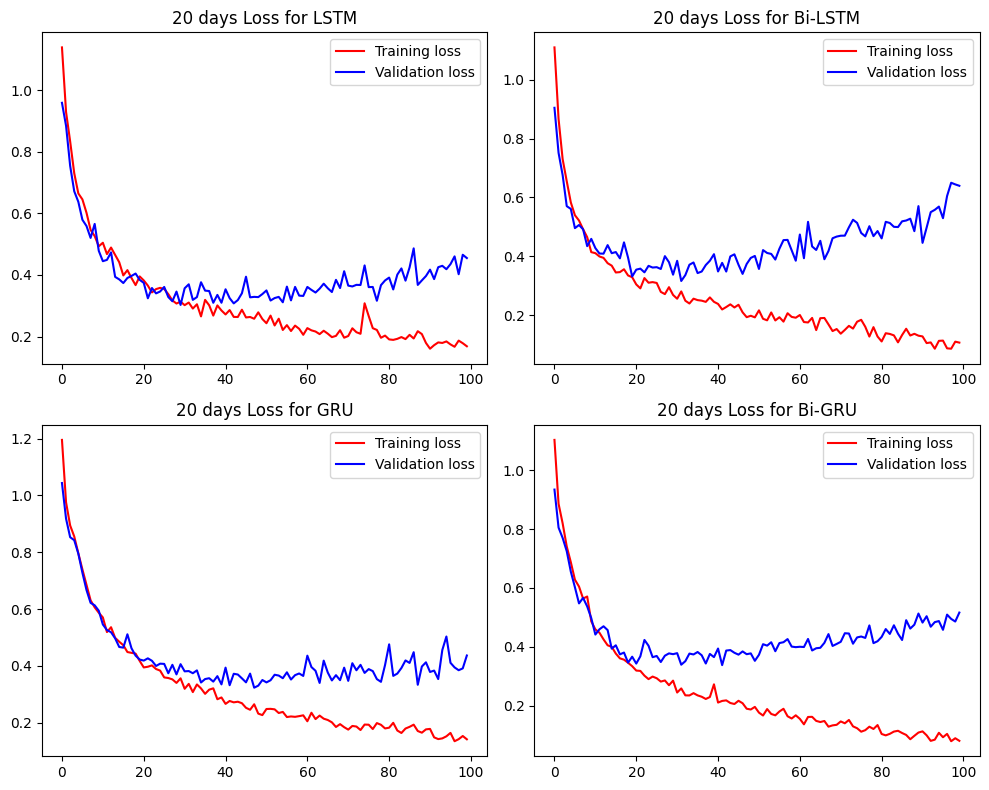

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
LSTM Accuracy = 0.8729508196721312

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
Bi-LSTM Accuracy = 0.8524590163934426

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
GRU Accuracy = 0.8688524590163934

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step
Bi-GRU Accuracy = 0.8688524590163934

Ensemble Accuracy = 0.8729508196721312

Ensemble Bi Accuracy = 0.8442622950819673

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

INKP Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


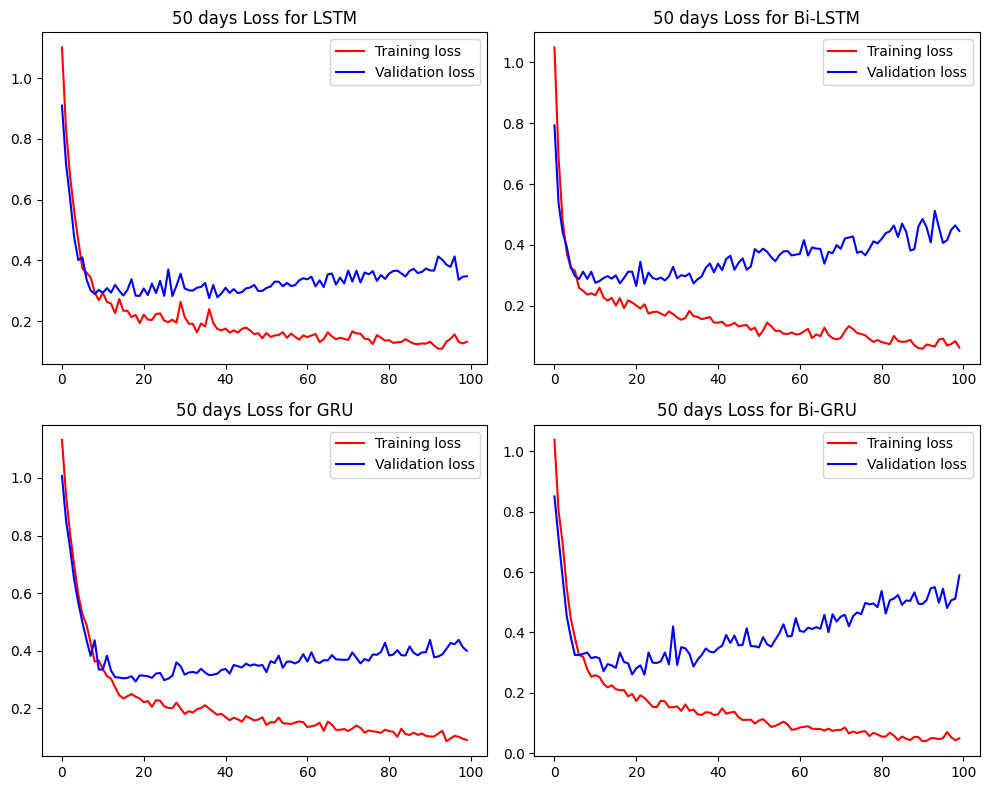

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
LSTM Accuracy = 0.9016393442622951

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step
Bi-LSTM Accuracy = 0.8811475409836066

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
GRU Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
Bi-GRU Accuracy = 0.8729508196721312

Ensemble Accuracy = 0.8975409836065574

Ensemble Bi Accuracy = 0.8811475409836066

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

MEDC Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


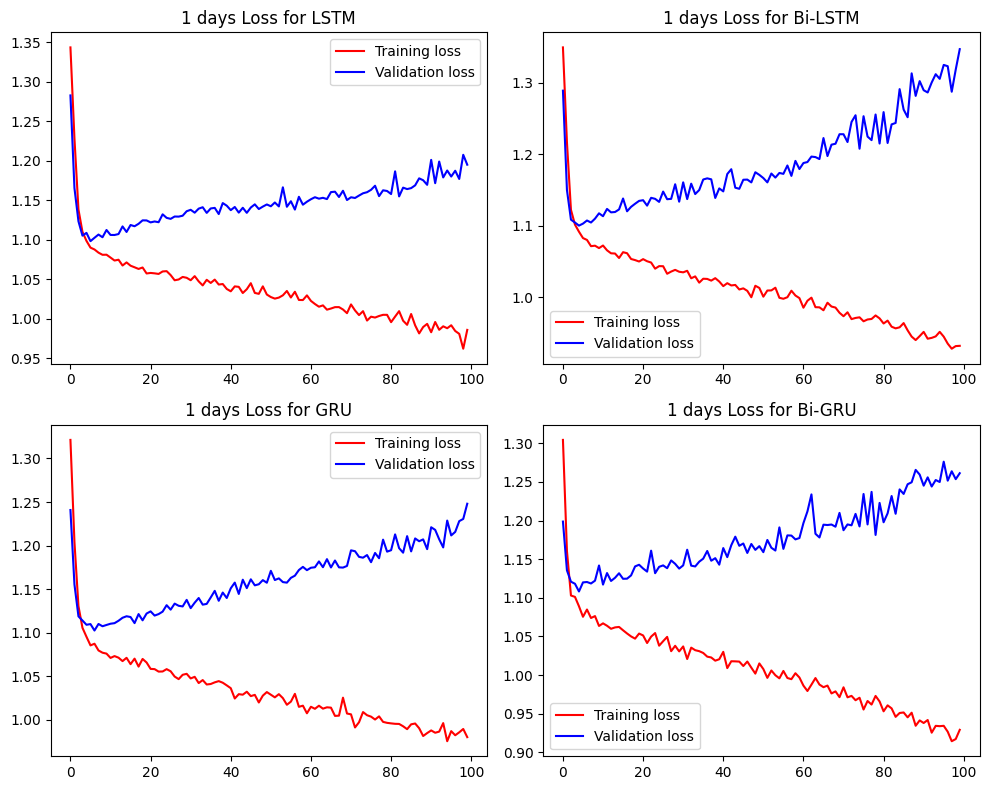

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.36885245901639346

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Bi-LSTM Accuracy = 0.36885245901639346

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
GRU Accuracy = 0.3360655737704918

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Bi-GRU Accuracy = 0.36475409836065575

Ensemble Accuracy = 0.38114754098360654

Ensemble Bi Accuracy = 0.36885245901639346

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

MEDC Target 5 days

Training LSTM...
Training Bi-LSTM...


In [ ]:
for stock in stocks:
  for day in days:
    print(f"{stock} Target {day} days\n")
    df = pd.read_csv(f'/content/drive/MyDrive/Riset_Saham/Fusion_Stock_Data/Fusion_Data_{stock}.csv')
    df.set_index('datetime', inplace=True)

    # Sort the DataFrame based on the index (oldest to most recent)
    df.sort_index(inplace=True)

    df = df[['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50',
            'RSI', 'MACD', 'MACD_SIGNAL', 'UPPERBAND', 'MIDDLEBAND', 'LOWERBAND', f'target_{day}', 'negative', 'positive', 'total_news', 'sentiment']]

    # Selecting features and target
    X = df.drop(columns=[f'target_{day}'], axis=1)
    y = df[f'target_{day}']
    y = to_categorical(y + 1)

    X_copy = X.copy()

    X = X[50:]
    y = y[50:]

    # Split Feature Dataset
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

    # Transform the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_X)
    X_val_scaled = scaler.transform(val_X)

    # Create sliding window
    data_size = X_copy.shape[0]
    window_size = day # Set window same as target day
    new_x = []

    for i in range(data_size - window_size + 1):
        new_x.append(X_copy[i:i + window_size])

    new_x = np.array(new_x)[50 + 1 - window_size:]

    new_x_scaled = np.zeros((new_x.shape[0], window_size, new_x.shape[2]))

    for i in range(new_x.shape[0]):
    # Convert to DataFrame to retain column names
      df_window = pd.DataFrame(new_x[i], columns=X.columns)
      new_x_scaled[i] = scaler.transform(df_window)

    # for i in range(new_x.shape[0]):
    #   new_x_scaled[i] = scaler.transform(new_x[i])

    train_X, val_X = train_test_split(new_x_scaled, test_size=0.2, random_state=0)

    model_lstm, model_bi_lstm, model_gru, model_bi_gru, history_lstm, history_bi_lstm, history_gru, history_bi_gru = create_train_model(train_X, train_y)

    plot_loss(history_lstm, history_bi_lstm, history_gru, history_bi_gru, day)

    val_y = np.argmax(val_y, axis=1) - 1 # get original categories

    print("Val Evaluation\n")
    pred_lstm = evaluate_model(model_lstm, "LSTM", val_X, val_y)
    pred_bi_lstm = evaluate_model(model_bi_lstm, "Bi-LSTM", val_X, val_y)
    pred_gru = evaluate_model(model_gru, "GRU", val_X, val_y)
    pred_bi_gru = evaluate_model(model_bi_gru, "Bi-GRU", val_X, val_y)

    pred_ensemble = ensemble(pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru, val_X, val_y)
    pred_ensemble_bi = ensemble_just_bi(pred_bi_lstm, pred_bi_gru, val_X, val_y)

    # Save Results
    print("Saving Results...\n")
    y = df[f'target_{day}']
    y = y[50:]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

    train_df, test_df = train_test_split(X, test_size=0.2,  random_state=0)
    train_df = train_df.assign(type='train')
    train_df = train_df.assign(ground_truth=list(y_train))
    train_df = train_df.assign(prediction=np.nan)
    test_df = test_df.assign(type='test')
    test_df = test_df.assign(ground_truth=list(y_val))
    test_df = test_df.assign(prediction=pred_ensemble)

    result_df = pd.concat([train_df, test_df])
    result_df.reset_index(inplace=True)

    try:
        os.makedirs(f'/content/drive/MyDrive/Riset_Saham/Result_Deep_Learning/{stock}')
    except Exception:
        pass
    result_df.to_csv(f'/content/drive/MyDrive/Riset_Saham/Result_Deep_Learning/{stock}/{stock}_Target_{day}.csv')

    print("Prediction Saved!\n")
    print("---------------------------------------------------------------------------\n")

In [5]:
stocks = ["PGAS", "TLKM"]
days = [1,5,10,20,50]

PGAS Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


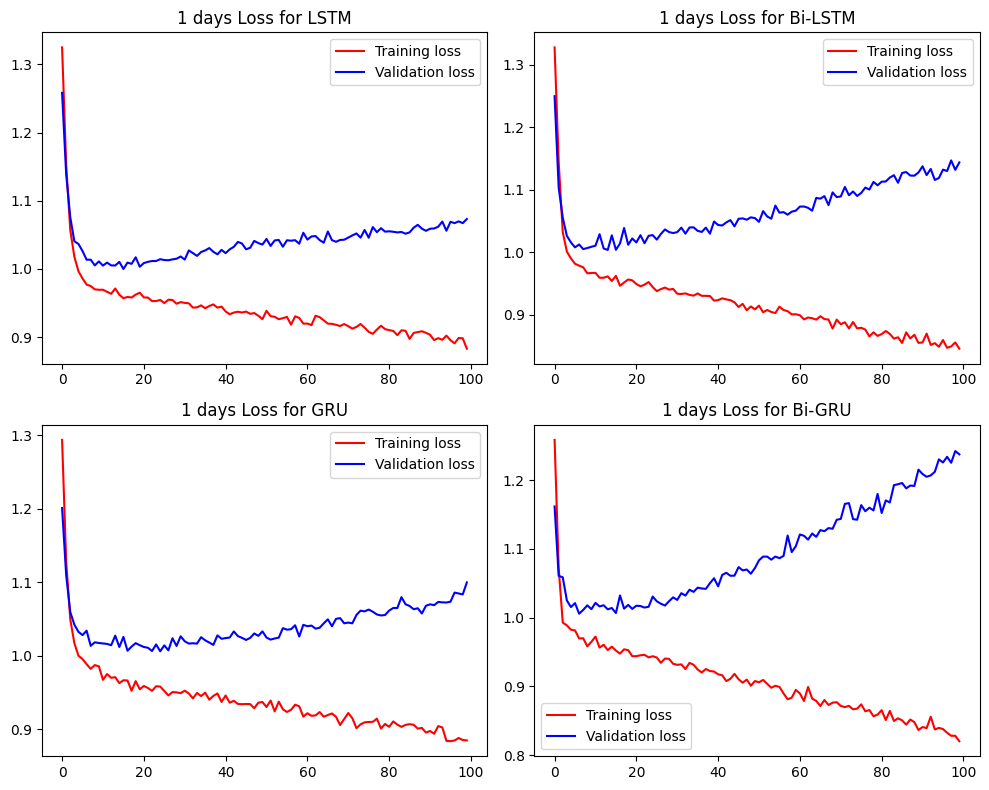

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
LSTM Accuracy = 0.5204918032786885

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
Bi-LSTM Accuracy = 0.5040983606557377



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
GRU Accuracy = 0.4959016393442623



8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
Bi-GRU Accuracy = 0.45491803278688525

Ensemble Accuracy = 0.5122950819672131

Ensemble Bi Accuracy = 0.47950819672131145

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

PGAS Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


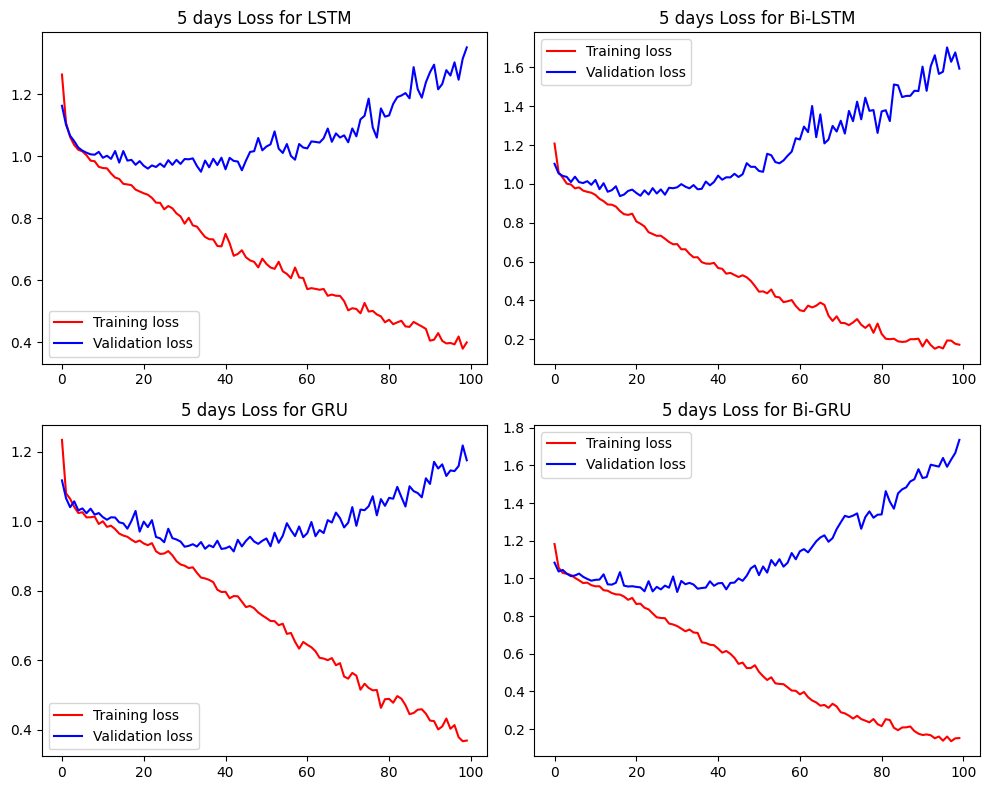

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.6352459016393442

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Bi-LSTM Accuracy = 0.6434426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
GRU Accuracy = 0.5737704918032787

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Bi-GRU Accuracy = 0.610655737704918

Ensemble Accuracy = 0.6229508196721312

Ensemble Bi Accuracy = 0.6188524590163934

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

PGAS Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


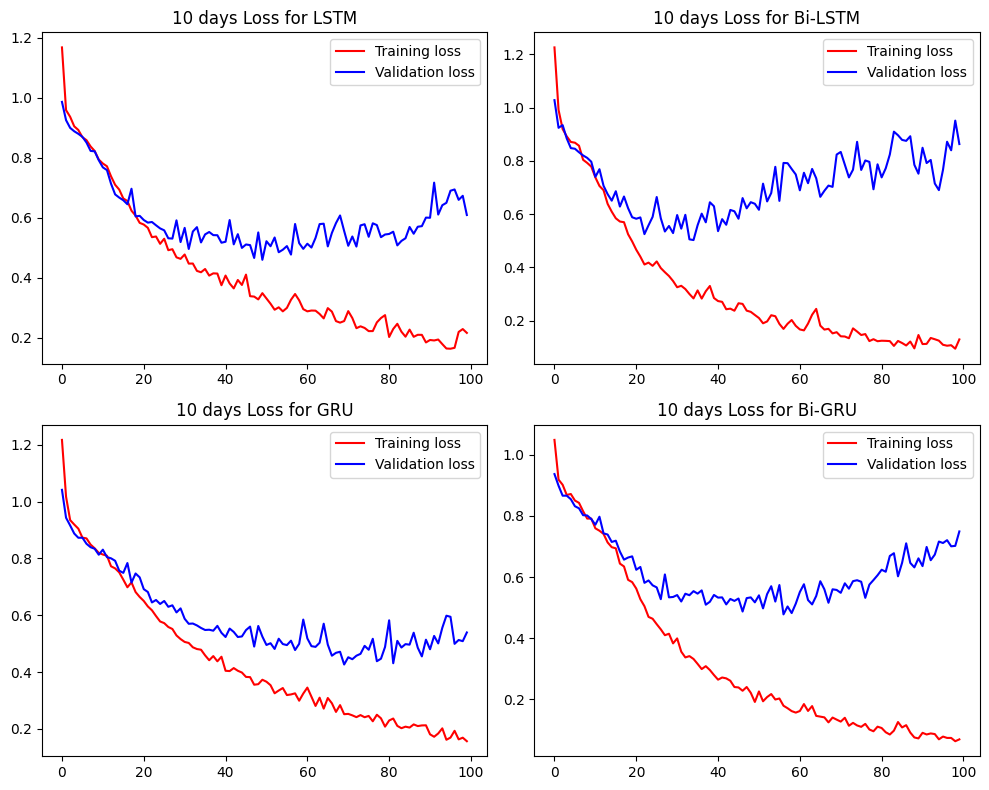

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
LSTM Accuracy = 0.8155737704918032

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
Bi-LSTM Accuracy = 0.7868852459016393

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
GRU Accuracy = 0.8237704918032787

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Bi-GRU Accuracy = 0.819672131147541

Ensemble Accuracy = 0.819672131147541

Ensemble Bi Accuracy = 0.8114754098360656

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

PGAS Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


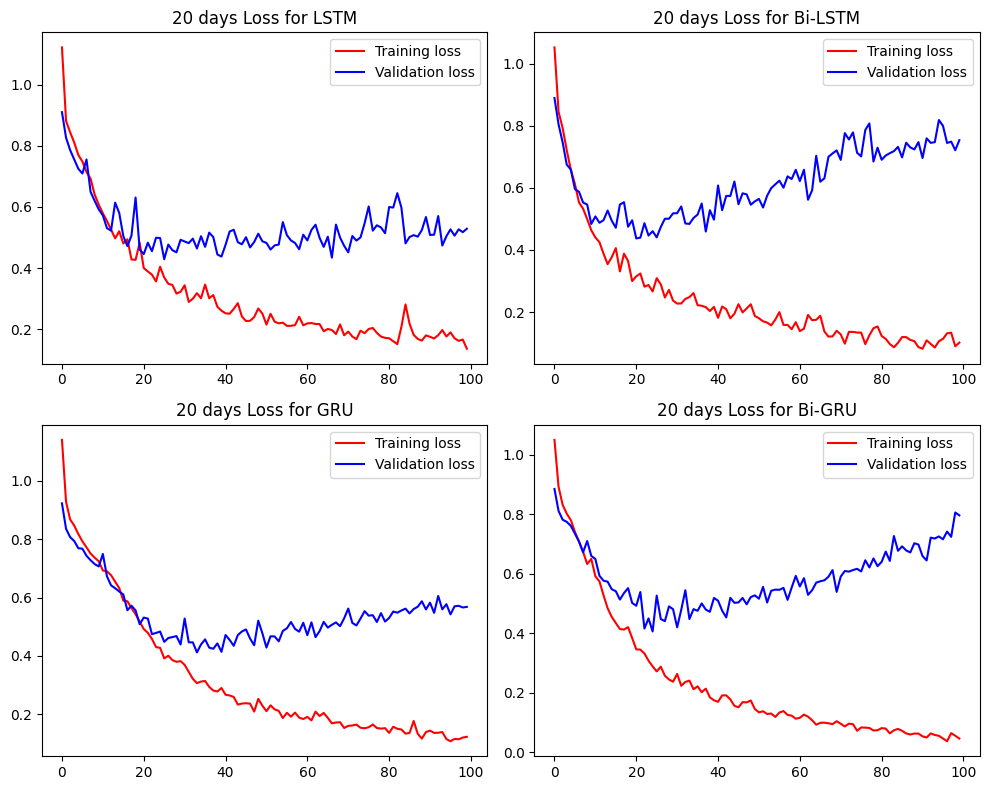

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
LSTM Accuracy = 0.8483606557377049

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step
Bi-LSTM Accuracy = 0.8319672131147541

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
GRU Accuracy = 0.8524590163934426

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
Bi-GRU Accuracy = 0.8524590163934426

Ensemble Accuracy = 0.8442622950819673

Ensemble Bi Accuracy = 0.8360655737704918

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

PGAS Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


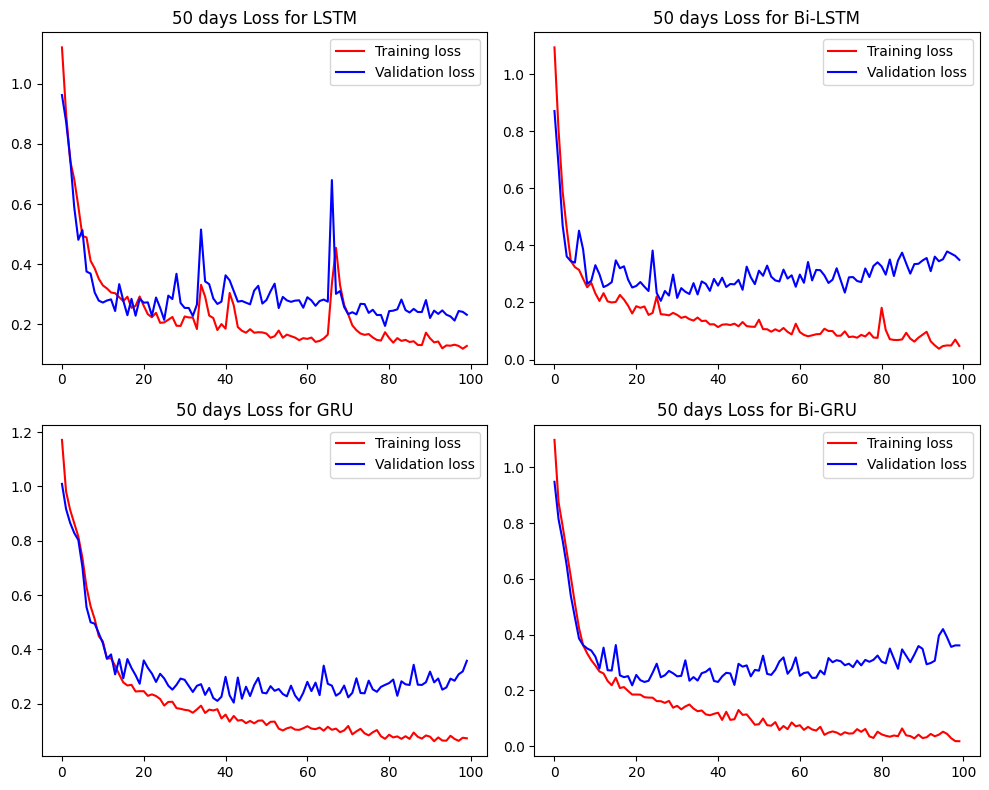

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
LSTM Accuracy = 0.9139344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step
Bi-LSTM Accuracy = 0.9385245901639344

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
GRU Accuracy = 0.9221311475409836

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
Bi-GRU Accuracy = 0.9385245901639344

Ensemble Accuracy = 0.9344262295081968

Ensemble Bi Accuracy = 0.9426229508196722

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

TLKM Target 1 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


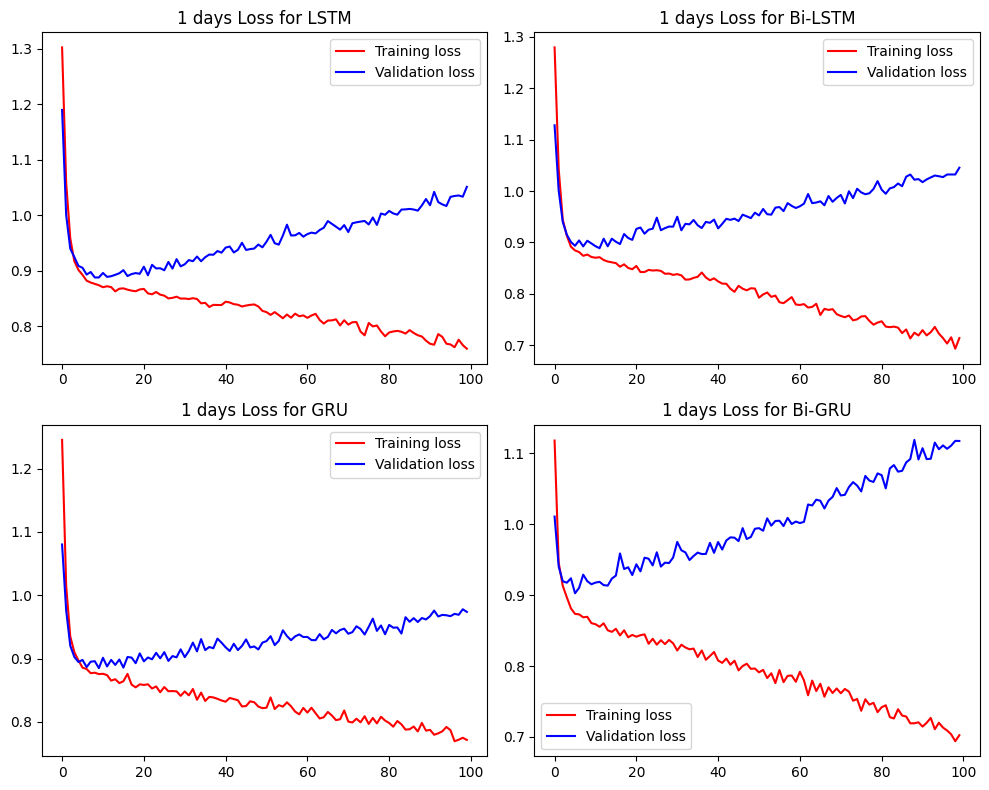

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
LSTM Accuracy = 0.6147540983606558

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Bi-LSTM Accuracy = 0.610655737704918

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
GRU Accuracy = 0.6311475409836066

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Bi-GRU Accuracy = 0.5901639344262295

Ensemble Accuracy = 0.610655737704918

Ensemble Bi Accuracy = 0.5983606557377049

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

TLKM Target 5 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


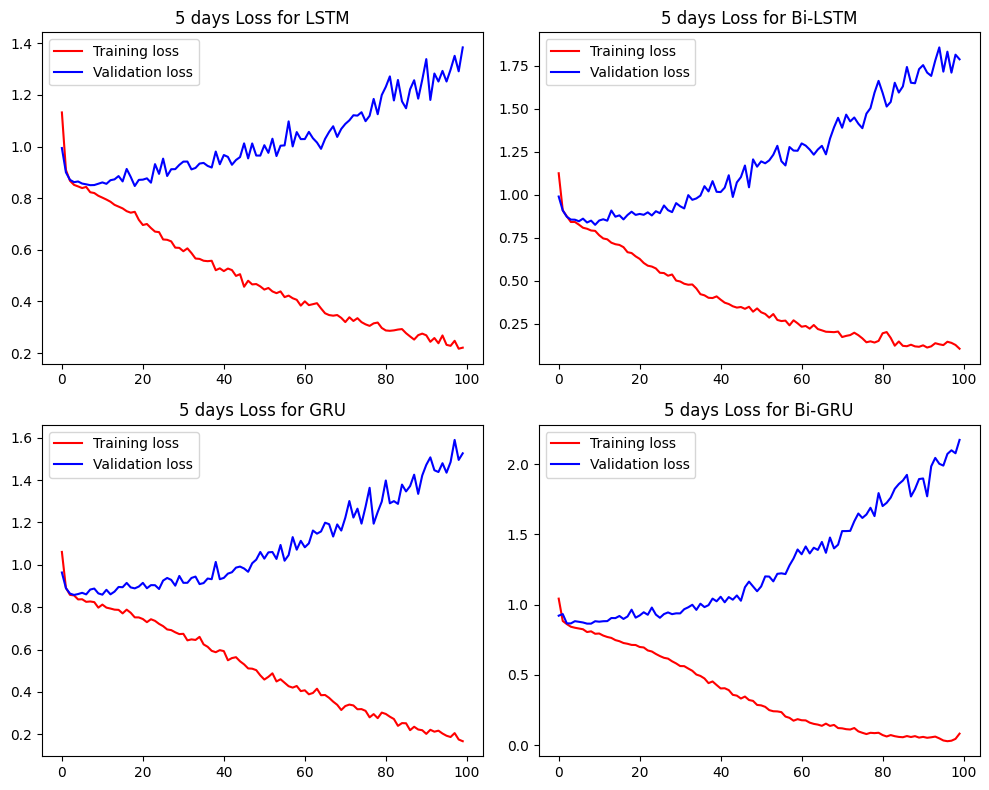

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
LSTM Accuracy = 0.6844262295081968

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Bi-LSTM Accuracy = 0.6270491803278688

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
GRU Accuracy = 0.6270491803278688

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Bi-GRU Accuracy = 0.6229508196721312

Ensemble Accuracy = 0.6598360655737705

Ensemble Bi Accuracy = 0.639344262295082

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

TLKM Target 10 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


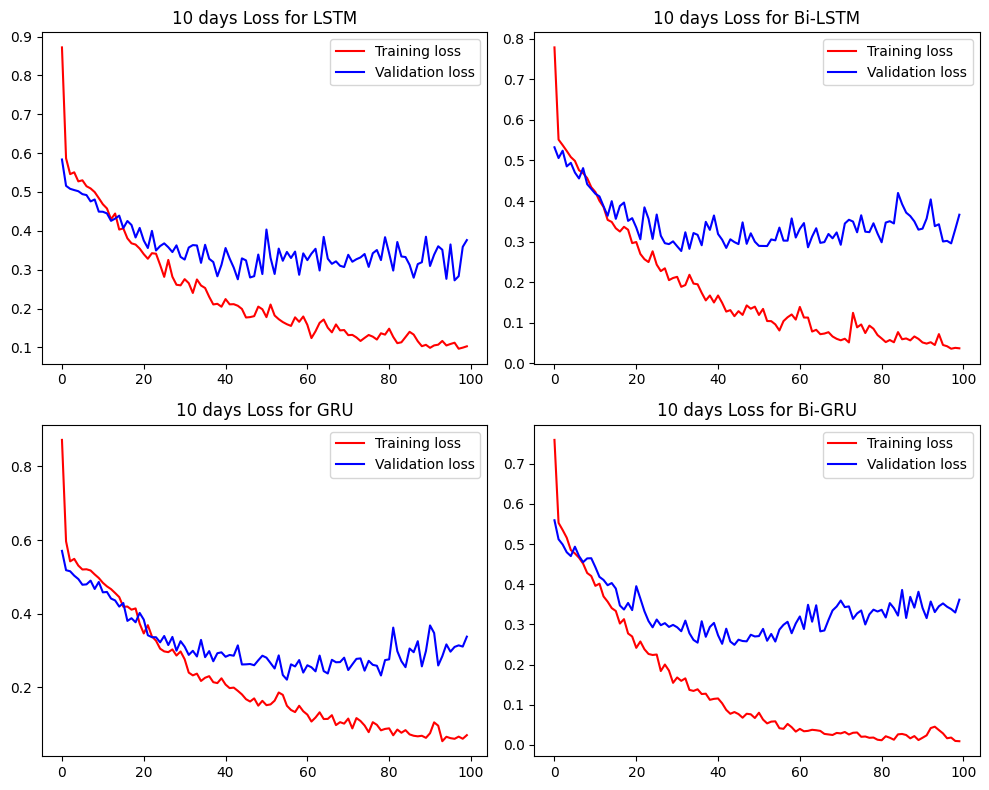

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
LSTM Accuracy = 0.889344262295082

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
Bi-LSTM Accuracy = 0.9180327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
GRU Accuracy = 0.930327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
Bi-GRU Accuracy = 0.9180327868852459

Ensemble Accuracy = 0.9262295081967213

Ensemble Bi Accuracy = 0.9262295081967213

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

TLKM Target 20 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


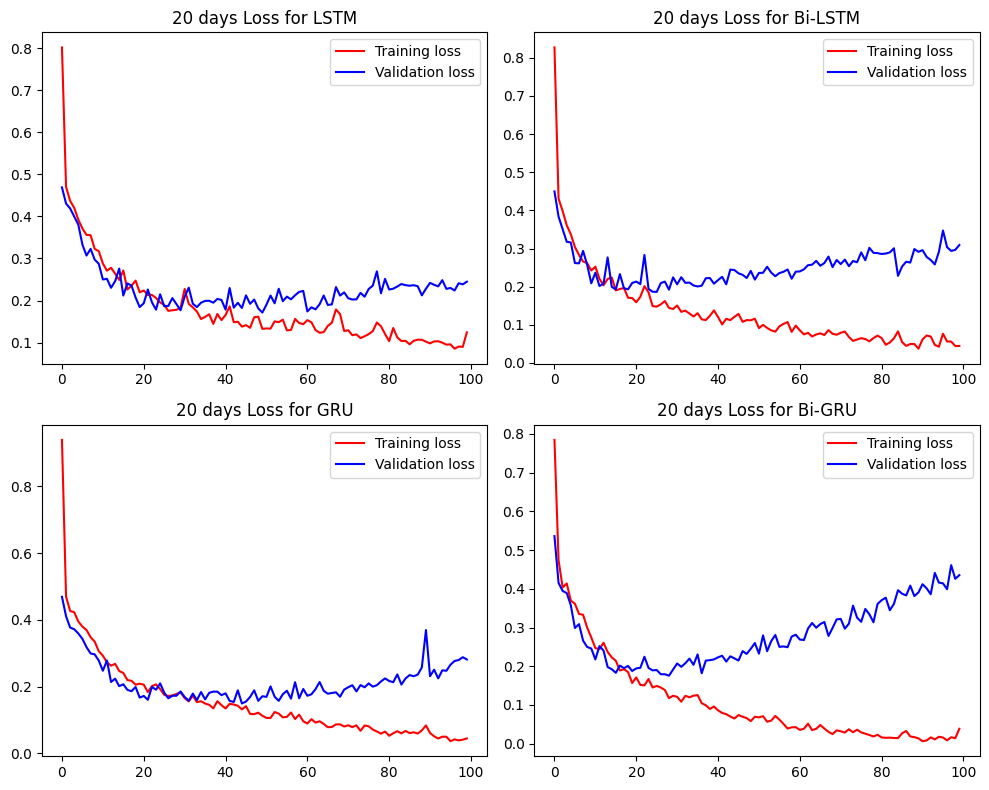

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
LSTM Accuracy = 0.9426229508196722

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
Bi-LSTM Accuracy = 0.9344262295081968

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
GRU Accuracy = 0.930327868852459

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
Bi-GRU Accuracy = 0.9467213114754098

Ensemble Accuracy = 0.9344262295081968

Ensemble Bi Accuracy = 0.9344262295081968

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------

TLKM Target 50 days

Training LSTM...
Training Bi-LSTM...
Training GRU...
Training Bi-GRU...


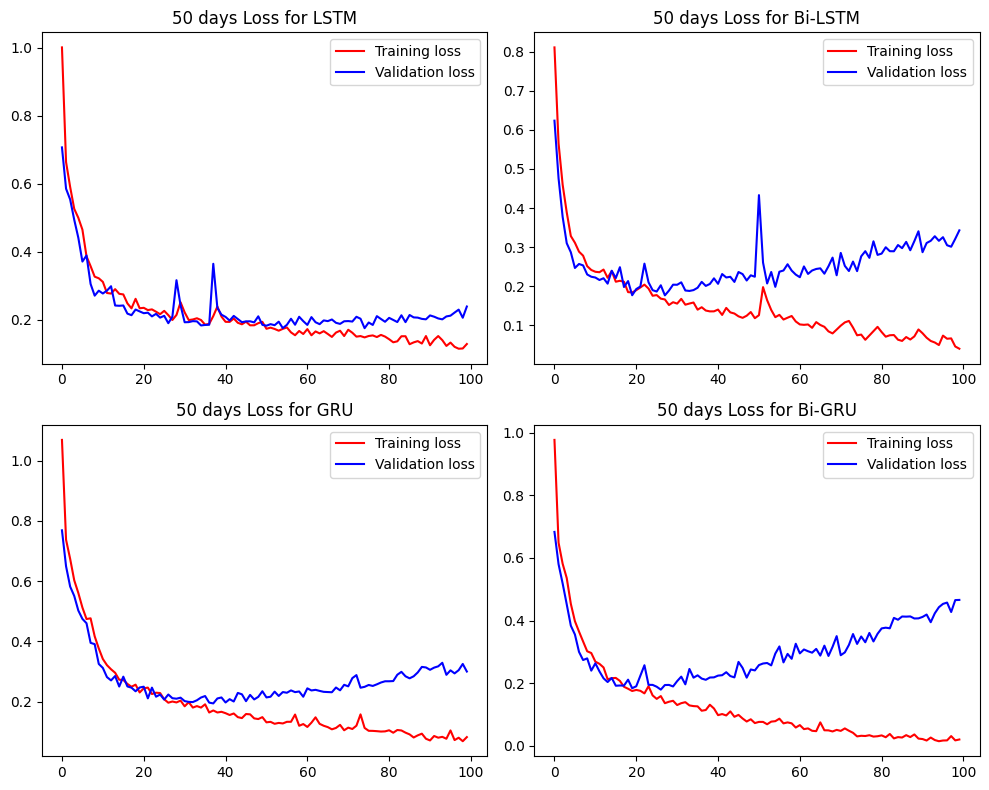

Val Evaluation

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
LSTM Accuracy = 0.9016393442622951

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Bi-LSTM Accuracy = 0.8975409836065574

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
GRU Accuracy = 0.8934426229508197

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step
Bi-GRU Accuracy = 0.9057377049180327

Ensemble Accuracy = 0.9016393442622951

Ensemble Bi Accuracy = 0.9016393442622951

Saving Results...

Prediction Saved!

---------------------------------------------------------------------------



In [6]:
for stock in stocks:
  for day in days:
    print(f"{stock} Target {day} days\n")
    df = pd.read_csv(f'/content/drive/MyDrive/Riset_Saham/Fusion_Stock_Data/Fusion_Data_{stock}.csv')
    df.set_index('datetime', inplace=True)

    # Sort the DataFrame based on the index (oldest to most recent)
    df.sort_index(inplace=True)

    df = df[['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50',
            'RSI', 'MACD', 'MACD_SIGNAL', 'UPPERBAND', 'MIDDLEBAND', 'LOWERBAND', f'target_{day}', 'negative', 'positive', 'total_news', 'sentiment']]

    # Selecting features and target
    X = df.drop(columns=[f'target_{day}'], axis=1)
    y = df[f'target_{day}']
    y = to_categorical(y + 1)

    X_copy = X.copy()

    X = X[50:]
    y = y[50:]

    # Split Feature Dataset
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

    # Transform the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_X)
    X_val_scaled = scaler.transform(val_X)

    # Create sliding window
    data_size = X_copy.shape[0]
    window_size = day # Set window same as target day
    new_x = []

    for i in range(data_size - window_size + 1):
        new_x.append(X_copy[i:i + window_size])

    new_x = np.array(new_x)[50 + 1 - window_size:]

    new_x_scaled = np.zeros((new_x.shape[0], window_size, new_x.shape[2]))

    for i in range(new_x.shape[0]):
    # Convert to DataFrame to retain column names
      df_window = pd.DataFrame(new_x[i], columns=X.columns)
      new_x_scaled[i] = scaler.transform(df_window)

    # for i in range(new_x.shape[0]):
    #   new_x_scaled[i] = scaler.transform(new_x[i])

    train_X, val_X = train_test_split(new_x_scaled, test_size=0.2, random_state=0)

    model_lstm, model_bi_lstm, model_gru, model_bi_gru, history_lstm, history_bi_lstm, history_gru, history_bi_gru = create_train_model(train_X, train_y)

    plot_loss(history_lstm, history_bi_lstm, history_gru, history_bi_gru, day)

    val_y = np.argmax(val_y, axis=1) - 1 # get original categories

    print("Val Evaluation\n")
    pred_lstm = evaluate_model(model_lstm, "LSTM", val_X, val_y)
    pred_bi_lstm = evaluate_model(model_bi_lstm, "Bi-LSTM", val_X, val_y)
    pred_gru = evaluate_model(model_gru, "GRU", val_X, val_y)
    pred_bi_gru = evaluate_model(model_bi_gru, "Bi-GRU", val_X, val_y)

    pred_ensemble = ensemble(pred_lstm, pred_bi_lstm, pred_gru, pred_bi_gru, val_X, val_y)
    pred_ensemble_bi = ensemble_just_bi(pred_bi_lstm, pred_bi_gru, val_X, val_y)

    # Save Results
    print("Saving Results...\n")
    y = df[f'target_{day}']
    y = y[50:]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

    train_df, test_df = train_test_split(X, test_size=0.2,  random_state=0)
    train_df = train_df.assign(type='train')
    train_df = train_df.assign(ground_truth=list(y_train))
    train_df = train_df.assign(prediction=np.nan)
    test_df = test_df.assign(type='test')
    test_df = test_df.assign(ground_truth=list(y_val))
    test_df = test_df.assign(prediction=pred_ensemble)

    result_df = pd.concat([train_df, test_df])
    result_df.reset_index(inplace=True)

    try:
        os.makedirs(f'/content/drive/MyDrive/Riset_Saham/Result_Deep_Learning/{stock}')
    except Exception:
        pass
    result_df.to_csv(f'/content/drive/MyDrive/Riset_Saham/Result_Deep_Learning/{stock}/{stock}_Target_{day}.csv')

    print("Prediction Saved!\n")
    print("---------------------------------------------------------------------------\n")